## Generate Partitioning

### Strategy 1

In [10]:
# --- Homophily-first (Strategy B) mapping for Open Images / FedScale ---
# Author: You + ChatGPT (2025-10-21)
# Requirements: numpy, pandas, scikit-learn
# Output: benchmark/dataset/data/openImg_client_data_mapping4/train.csv

import os, json, pickle, random, math, sys
from collections import OrderedDict, defaultdict, Counter
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# -------------------------
# 0) CONFIG
# -------------------------
BASE_HOME = "/users/eleves-a/2024/baptiste.geisenberger/FedScale"

PATH_ORIG = os.path.join(BASE_HOME, "benchmark/dataset/data/openImg_client_data_mapping_og/train.csv")
PATH_CLIENTS = os.path.join(BASE_HOME, "benchmark/dataset/data/clients.pkl")
PATH_RANKS_JSON = os.path.join(BASE_HOME, "thirdparty/bliss/clusters.json")
PATH_OUT = os.path.join(BASE_HOME, "benchmark/dataset/data/openImg_client_data_mapping4/train.csv")

# Control knobs (tweak as you like)
seed = 42
homo_strength = 1          # [0..1], 1 = very strong homophily within device clusters
rho_size_target = 0.7       # desired Spearman correlation between device quality and dataset size
K_label = 200                # label-cluster count
cluster_definition = "rank_only"   # "rank_plus_consumer" or "rank_only"
epsilon_homo = 0.05          # small slack for homophily (not used for quota reshuffle in this base version, but reserved)

np.random.seed(seed)
random.seed(seed)

# -------------------------
# 1) UTILS
# -------------------------
def safe_print(*args, **kwargs):
    print(*args, **kwargs, flush=True)

# --- drop-in replacement for the buggy spearmanr_numpy ---

def spearmanr_numpy(x, y):
    """
    Spearman rank correlation with average ranks on ties.
    Uses SciPy if available; otherwise falls back to a stable Pandas-based implementation.
    Returns 0.0 for degenerate (constant) inputs.
    """
    x = np.asarray(list(x))
    y = np.asarray(list(y))
    n = min(len(x), len(y))
    if n == 0:
        return 0.0
    x = x[:n]
    y = y[:n]

    # Try SciPy if present
    try:
        from scipy.stats import spearmanr as _spearmanr
        r = _spearmanr(x, y).correlation
        if np.isnan(r):
            return 0.0
        return float(r)
    except Exception:
        pass

    # Fallback: rank via Pandas (average method for ties), then Pearson on ranks
    rx = pd.Series(x).rank(method="average").to_numpy(dtype=float)
    ry = pd.Series(y).rank(method="average").to_numpy(dtype=float)

    rx -= rx.mean()
    ry -= ry.mean()
    denom = np.sqrt((rx**2).sum() * (ry**2).sum())
    if denom == 0 or np.isnan(denom):
        return 0.0
    return float((rx * ry).sum() / denom)

def choose_kmeans(n_clusters):
    # Favor MiniBatchKMeans for speed/stability on medium-large data
    return MiniBatchKMeans if n_clusters > 64 else KMeans

def topk_labels_from_vec(counts_row, label_cols, k=5):
    # counts_row is a 1D np.array (counts, not normalized)
    idx = np.argsort(-counts_row)[:k]
    return [int(label_cols[i]) for i in idx if counts_row[i] > 0]

def normalize_rows_l1(X):
    X = X.astype(np.float64, copy=False)
    row_sums = X.sum(axis=1, keepdims=True) + 1e-12
    return X / row_sums

# -------------------------
# 2) LOAD DATA
# -------------------------
safe_print("Loading original FedScale mapping:", PATH_ORIG)
df = pd.read_csv(PATH_ORIG)
df["client_id"] = df["client_id"].astype(str)   # <-- add this
required_cols = {"client_id", "sample_path", "label_name", "label_id"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Original CSV missing columns: {missing}")

# Build per-original-client stats (group size + label histogram)
safe_print("Computing per-original-client stats (this may take a moment)...")
# counts per (client_id, label_id)
counts = df.groupby(["client_id", "label_id"]).size().rename("cnt").reset_index()
# pivot to wide matrix (clients x label_id)
pivot = counts.pivot(index="client_id", columns="label_id", values="cnt").fillna(0).sort_index(axis=1)
label_cols = list(pivot.columns)
client_ids_orig = list(pivot.index.astype(str))
P_counts = pivot.to_numpy(dtype=np.float64)              # raw counts matrix (M x L)
P = normalize_rows_l1(P_counts)                          # normalized label distribution
n_per_group = P_counts.sum(axis=1).astype(int)           # dataset sizes (M)
M = len(client_ids_orig)
L = len(label_cols)
safe_print(f"Found M={M} original groups, L={L} labels.")

# -------------------------
# 3) LOAD DEVICES + RANKS
# -------------------------
safe_print("Loading devices:", PATH_CLIENTS)
with open(PATH_CLIENTS, "rb") as f:
    clients_od = pickle.load(f)  # OrderedDict-like: {device_id: feature_dict}

if not isinstance(clients_od, dict):
    raise ValueError("clients.pkl did not load as a (ordered) dict of device_id -> feature dict")

safe_print("Loading model->rank mapping (via models[] arrays):", PATH_RANKS_JSON)
import re
with open(PATH_RANKS_JSON, "r") as f:
    cluster_items = json.load(f)  # list of { "models": [...], "rank": int }

def norm_a(s: str) -> str:
    s = str(s or "").lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

def norm_b(s: str) -> str:
    s = str(s or "").lower()
    s = re.sub(r"[^a-z0-9]+", "", s)
    return s

# Build exact lookup tables from clusters.json
model_to_rank_exact_a = {}
model_to_rank_exact_b = {}
cluster_models = []  # (normA, normB, rank, original)

for obj in cluster_items:
    rank = obj.get("rank", None)
    models_list = obj.get("models", None)
    if models_list is None:  # backwards-compat if file uses singular "model"
        single = obj.get("model", None)
        models_list = [single] if single is not None else []
    if rank is None:
        continue
    try:
        rank = int(rank)
    except Exception:
        continue
    for m in models_list:
        na = norm_a(m)
        nb = norm_b(m)
        cluster_models.append((na, nb, rank, m))
        if na:
            # if duplicates exist, last write wins (ranks should be consistent anyway)
            model_to_rank_exact_a[na] = rank
        if nb:
            model_to_rank_exact_b[nb] = rank

def lookup_rank(model_str: str):
    """Exact match on normalized forms; then unique substring fallback."""
    na = norm_a(model_str)
    nb = norm_b(model_str)
    r = model_to_rank_exact_a.get(na)
    if r is not None:
        return r, "exactA"
    r = model_to_rank_exact_b.get(nb)
    if r is not None:
        return r, "exactB"
    # substring fallback: require a unique rank match
    candidates = set()
    for c_na, c_nb, rnk, _orig in cluster_models:
        if not c_na: 
            continue
        if c_na in na or na in c_na or (c_nb and (c_nb in nb or nb in c_nb)):
            candidates.add(rnk)
            if len(candidates) > 1:
                return None, "ambiguous"
    if len(candidates) == 1:
        return list(candidates)[0], "substring"
    return None, "none"

# Build devices dataframe and map ranks
dev_rows = []
for dev_id, feats in clients_od.items():
    feats = feats if isinstance(feats, dict) else {}
    model = str(feats.get("model", "") or "")
    rnk, how = lookup_rank(model)
    dev_rows.append({
        "device_id": str(dev_id),
        "model": model,
        "rank": rnk,
        "rank_lookup": how,
        # keep a few fields (ignored for rank-only clustering, but handy for debug)
        "brand": feats.get("brand", None),
        "OS": feats.get("OS", feats.get("os", None)),
        "osVersion": feats.get("osVersion", feats.get("os_version", None)),
        "RAM": feats.get("RAM", feats.get("ram", None)),
        "storage": feats.get("internal_memory", feats.get("storage", None)),
        "GPU": feats.get("GPU", feats.get("gpu", None)),
        "CPU": feats.get("CPU", feats.get("cpu", None)),
        "release_year": feats.get("release_year", None),
        "msrp": feats.get("msrp", feats.get("price", None)),
    })
devices_df_all = pd.DataFrame(dev_rows)

# Diagnostics
tot = len(devices_df_all)
n_exact = (devices_df_all["rank_lookup"].isin(["exactA","exactB"])).sum()
n_sub   = (devices_df_all["rank_lookup"] == "substring").sum()
n_amb   = (devices_df_all["rank_lookup"] == "ambiguous").sum()
n_none  = (devices_df_all["rank_lookup"] == "none").sum()
safe_print(f"Rank mapping summary: total={tot}, exact={n_exact}, substring={n_sub}, ambiguous={n_amb}, missing={n_none}")

if n_amb > 0:
    sample = devices_df_all.loc[devices_df_all["rank_lookup"]=="ambiguous", ["device_id","model"]].head(5).to_dict(orient="records")
    safe_print("Examples of ambiguous model→rank matches (first 5):", sample)

if n_none > 0:
    sample = devices_df_all.loc[devices_df_all["rank_lookup"]=="none", ["device_id","model"]].head(5).to_dict(orient="records")
    safe_print("Examples of missing model→rank matches (first 5):", sample)

# Conservative fallback: impute missing/ambiguous to lowest end (27)
missing_or_amb = devices_df_all["rank"].isna()
if missing_or_amb.sum() > 0:
    safe_print(f"Imputing rank=27 for {int(missing_or_amb.sum())} devices with no reliable rank match.")
    devices_df_all.loc[missing_or_amb, "rank"] = 27

# Quality score (higher = higher-end)
devices_df_all["rank"] = devices_df_all["rank"].astype(int)
devices_df_all["quality"] = 28 - devices_df_all["rank"]


# -------------------------
# 4) DEVICE CLUSTERING (rank_plus_consumer with fallback)
# -------------------------
def cluster_devices(dev_df, strategy="rank_plus_consumer", seed=42):
    """
    Returns:
      dev_df_used: DataFrame of devices with columns [device_id, rank, quality, dev_cluster_id]
      clusters: dict cluster_id -> list of device_id
    """
    # Filter to devices with rank if possible; if too few, impute rank=27
    df = dev_df.copy()
    df_ranked = df[~df["rank"].isna()].copy()
    if len(df_ranked) < M:
        safe_print(f"Not enough ranked devices ({len(df_ranked)}) to cover M={M}. Imputing rank=27 for missing.")
        df.loc[df["rank"].isna(), "rank"] = 27
        df["quality"] = 28 - df["rank"]
        df_ranked = df

    # we only need M devices; preselect proportionally by rank to keep diversity
    # but we need cluster structure first -> form clusters on full ranked set, then sample
    def make_cluster_id(rank, sub=None):
        return f"r{int(rank)}" if sub is None else f"r{int(rank)}_s{sub}"

    clusters = defaultdict(list)

    if strategy == "rank_plus_consumer":
        # consumer-ish feature matrix per rank
        # build feature set: try numeric: RAM, storage, msrp, release_year ; categorical: brand, OS, GPU, CPU
        cand_num = ["RAM", "storage", "msrp", "release_year"]
        cand_cat = ["brand", "OS", "GPU", "CPU"]

        num_exist = [c for c in cand_num if c in df_ranked.columns]
        cat_exist = [c for c in cand_cat if c in df_ranked.columns]

        # Count how many non-null in these columns to decide feasibility
        enough_signal = False
        if num_exist or cat_exist:
            nn = 0
            for c in num_exist + cat_exist:
                nn += df_ranked[c].notna().sum()
            enough_signal = nn > 0.3 * len(df_ranked)  # heuristic

        if not enough_signal:
            safe_print("Consumer features too sparse; falling back to rank_only clustering.")
            strategy = "rank_only"

    if strategy == "rank_only":
        for _, row in df_ranked.iterrows():
            clusters[make_cluster_id(row["rank"])].append(row["device_id"])

    else:
        # Within each rank, k-means over consumer features
        # Build encodings
        def prep_features(subdf):
            X_parts = []
            # numeric
            num = subdf[num_exist].copy()
            for c in num.columns:
                # try to coerce to float
                num[c] = pd.to_numeric(num[c], errors="coerce")
            num = num.fillna(num.median(numeric_only=True))
            if num.shape[1] > 0:
                Xn = StandardScaler().fit_transform(num.to_numpy())
                X_parts.append(Xn)
            # categorical: simple target code via factorize indices (cheap + seed-deterministic)
            for c in cat_exist:
                codes, _ = pd.factorize(subdf[c].astype(str).fillna("NA_"+c))
                codes = codes.astype(float).reshape(-1, 1)
                X_parts.append(codes)
            if not X_parts:
                # all missing; fallback to zeros
                X_parts = [np.zeros((len(subdf), 1))]
            X = np.concatenate(X_parts, axis=1)
            return X

        for r, g in df_ranked.groupby("rank"):
            X = prep_features(g)
            Nr = len(g)
            Kr = max(1, int(round(min(math.sqrt(Nr/50.0), 8))))
            Cls = choose_kmeans(Kr)
            km = Cls(n_clusters=Kr, random_state=seed, n_init="auto")
            labels = km.fit_predict(X)
            for sub in range(Kr):
                dev_ids = g.iloc[np.where(labels == sub)[0]]["device_id"].tolist()
                clusters[make_cluster_id(r, sub)].extend(dev_ids)

    # capacity selection: we need exactly M devices total
    # allocate per cluster proportionally to cluster size
    all_devs = sum((v for v in clusters.values()), [])
    N_all = len(all_devs)
    if N_all < M:
        safe_print(f"WARNING: total devices after clustering = {N_all} < M={M}. Will sample from full ranked pool to fill.")
        pool = df_ranked["device_id"].tolist()
        extra = np.random.choice(pool, size=M-N_all, replace=False).tolist()
        clusters["overflow"].extend(extra)
        N_all = M

    alloc = {}
    base = 0
    for cid, devs in clusters.items():
        alloc[cid] = (M * len(devs)) / N_all
    # round with largest remainder
    alloc_int = {cid: int(math.floor(v)) for cid, v in alloc.items()}
    remainder = M - sum(alloc_int.values())
    remainders = sorted([(alloc[cid]-alloc_int[cid], cid) for cid in alloc], reverse=True)
    for _, cid in remainders[:remainder]:
        alloc_int[cid] += 1

    # sample devices within each cluster
    selected = []
    for cid, devs in clusters.items():
        k = alloc_int[cid]
        if k <= 0:
            continue
        if len(devs) <= k:
            chosen = devs
        else:
            chosen = list(np.random.default_rng(seed).choice(devs, size=k, replace=False))
        for d in chosen:
            selected.append((d, cid))

    # Build dev_df_used
    dev_df_used = df_ranked[df_ranked["device_id"].isin([d for d,_ in selected])].copy()
    cid_map = {d: c for d,c in selected}
    dev_df_used["dev_cluster_id"] = dev_df_used["device_id"].map(cid_map)

    # sometimes rounding can be off by a few due to dedup; adjust
    if len(dev_df_used) != M:
        safe_print(f"Adjusting selection to exactly M={M}. Currently {len(dev_df_used)}.")
        pool_remaining = df_ranked[~df_ranked["device_id"].isin(dev_df_used["device_id"])].copy()
        add = M - len(dev_df_used)
        if add > 0 and len(pool_remaining) >= add:
            extra_ids = list(np.random.default_rng(seed).choice(pool_remaining["device_id"].tolist(), size=add, replace=False))
            extra_df = pool_remaining[pool_remaining["device_id"].isin(extra_ids)].copy()
            # assign them to the largest clusters
            size_by_c = dev_df_used.groupby("dev_cluster_id").size().to_dict()
            if not size_by_c:
                target_c = "r1"
                size_by_c = {target_c: 0}
            sorted_c = sorted(size_by_c.items(), key=lambda x: -x[1])
            chosen_c = [sorted_c[i % len(sorted_c)][0] for i in range(add)]
            extra_df["dev_cluster_id"] = chosen_c
            dev_df_used = pd.concat([dev_df_used, extra_df], ignore_index=True)
        elif add < 0:
            # drop random -add rows
            drop_ids = list(np.random.default_rng(seed).choice(dev_df_used["device_id"].tolist(), size=-add, replace=False))
            dev_df_used = dev_df_used[~dev_df_used["device_id"].isin(drop_ids)].copy()

    # finalize clusters mapping on used devices
    clusters_used = defaultdict(list)
    for _, row in dev_df_used.iterrows():
        clusters_used[row["dev_cluster_id"]].append(row["device_id"])

    return dev_df_used, dict(clusters_used)

dev_df_used, clusters_used = cluster_devices(devices_df_all, cluster_definition, seed=seed)
safe_print(f"Selected exactly {len(dev_df_used)} devices (should equal M={M}).")
assert len(dev_df_used) == M, f"Device selection failed to reach M={M}"

# mean quality per device cluster (used later to bias big datasets towards higher-quality clusters)
mean_q_by_c = dev_df_used.groupby("dev_df_used".replace("dev_df_used","dev_cluster_id") if False else "dev_cluster_id")["quality"].mean().to_dict()

# -------------------------
# 5) LABEL-SPACE CLUSTERING (spherical-ish k-means on normalized vectors)
# -------------------------
safe_print("Label-space clustering...")
# SVD to 50 dims (works with dense)
svd = TruncatedSVD(n_components=min(50, min(P.shape)-1), random_state=seed)
Z = svd.fit_transform(P)  # (M x d)
# L2 normalize rows
Z_norm = Z / (np.linalg.norm(Z, axis=1, keepdims=True) + 1e-12)

KM = choose_kmeans(K_label)
km = KM(n_clusters=K_label, random_state=seed, n_init="auto")
lbl_assign = km.fit_predict(Z_norm)  # z(i) in [0..K_label-1]
centroids = km.cluster_centers_  # d-dim prototypes on sphere-ish

# Build per-label-cluster lists of dataset indices (by size desc)
idx_by_k = {k: [] for k in range(K_label)}
for i, k in enumerate(lbl_assign):
    idx_by_k[k].append(i)
for k in range(K_label):
    idx = idx_by_k[k]
    idx_sorted = sorted(idx, key=lambda i: -n_per_group[i])  # largest first
    idx_by_k[k] = idx_sorted

size_k = {k: len(idx_by_k[k]) for k in range(K_label)}

# -------------------------
# 6) HOMOPHILY PREFERENCES & GREEDY BLOCK ALLOCATION X[c,k]
# -------------------------
safe_print("Building homophily preferences & greedy block allocation...")

# capacities per device cluster
cap_by_c = {c: len(devs) for c, devs in clusters_used.items()}

# how many themes per cluster
def themes_for_cluster(homo_strength):
    # 1 theme when homo=1, up to ~5 when homo=0
    return max(1, 1 + round((1 - homo_strength) * 4))

T_by_c = {c: themes_for_cluster(homo_strength) for c in cap_by_c}

# Preferred label clusters per device cluster: start from biggest label clusters, diversify across device clusters
label_clusters_sorted = sorted(size_k.items(), key=lambda kv: -kv[1])
# round-robin head picks to diversify
preferred_by_c = {}
c_list = list(cap_by_c.keys())
rr_ptr = 0
for c in c_list:
    prefs = set()
    attempts = 0
    while len(prefs) < T_by_c[c] and attempts < 3*K_label:
        k = label_clusters_sorted[rr_ptr % len(label_clusters_sorted)][0]
        prefs.add(k)
        rr_ptr += 1
        attempts += 1
    preferred_by_c[c] = list(prefs)

# weights W[c,k]
W = defaultdict(dict)
for c in cap_by_c:
    prefs = set(preferred_by_c[c])
    for k in range(K_label):
        if k in prefs:
            W[c][k] = 0.9 * homo_strength + 0.1
        else:
            W[c][k] = (1 - homo_strength) * 0.5

# Greedy fill X[c,k] maximizing weights subject to caps and size_k supply
X = defaultdict(lambda: defaultdict(int))
size_left = size_k.copy()
cap_left = cap_by_c.copy()

# iterate device clusters in descending capacity
for c, cap in sorted(cap_by_c.items(), key=lambda kv: -kv[1]):
    if cap <= 0:
        continue
    # First fill from preferred set, choosing k with largest remaining size
    prefs = preferred_by_c[c]
    # two passes: preferred then non-preferred
    for pass_idx in range(2):
        ks = (prefs if pass_idx == 0 else [k for k in range(K_label) if k not in prefs])
        # greedy by descending size_left
        ks_sorted = sorted(ks, key=lambda k: (-W[c][k], -size_left.get(k,0)))
        for k in ks_sorted:
            if cap_left[c] == 0:
                break
            take = min(cap_left[c], size_left.get(k, 0))
            if take <= 0:
                continue
            X[c][k] += take
            cap_left[c] -= take
            size_left[k] -= take
        if cap_left[c] == 0:
            break

# Feasibility: if any cap remains (very unlikely), backfill from any k with supply
if sum(cap_left.values()) > 0:
    safe_print("Backfilling residual capacities...")
    # flatten ks by remaining size
    k_pool = sorted([k for k,v in size_left.items() if v>0], key=lambda k: -size_left[k])
    for c in cap_left:
        while cap_left[c] > 0 and k_pool:
            k = k_pool[0]
            take = min(cap_left[c], size_left[k])
            X[c][k] += take
            cap_left[c] -= take
            size_left[k] -= take
            if size_left[k] == 0:
                k_pool.pop(0)

# Sanity
tot_X = sum(sum(X[c].values()) for c in X)
assert tot_X == M, f"Block allocation mismatch: assigned {tot_X}, expected {M}"

# -------------------------
# 7) DISTRIBUTE SPECIFIC DATASETS: big sizes -> higher-quality clusters
# -------------------------
safe_print("Distributing specific datasets to clusters (size-aware)...")

# cluster mean quality for ordering
mean_q_by_c = {c: float(np.mean(dev_df_used[dev_df_used["dev_cluster_id"] == c]["quality"])) for c in clusters_used}

# For each label cluster k, slice its sorted dataset list across device clusters that requested X[c,k],
# assigning larger slices to clusters with higher mean quality.
datasets_for_cluster = {c: [] for c in clusters_used}
for k in range(K_label):
    # build demand list [(c, count)]
    demand = [(c, X[c][k]) for c in clusters_used if X[c][k] > 0]
    if not demand:
        continue
    # sort demand clusters by mean cluster quality desc
    demand_sorted = sorted(demand, key=lambda t: -mean_q_by_c.get(t[0], 0.0))
    # take top |demand| from idx_by_k[k], already sorted desc by size
    pool = idx_by_k[k]
    need = sum(cnt for _, cnt in demand_sorted)
    if need > len(pool):
        # should not happen due to X construction, but guard
        need = len(pool)
    take_idxs = pool[:need]
    idx_ptr = 0
    for c, cnt in demand_sorted:
        if cnt <= 0:
            continue
        chunk = take_idxs[idx_ptr: idx_ptr+cnt]
        idx_ptr += cnt
        datasets_for_cluster[c].extend(chunk)
    # shrink the pool
    idx_by_k[k] = pool[need:]

# Within each cluster, we now have a multiset of dataset indices; order by size desc
for c in datasets_for_cluster:
    datasets_for_cluster[c] = sorted(datasets_for_cluster[c], key=lambda i: -n_per_group[i])

# -------------------------
# 8) ASSIGN DEVICES TO DATASETS INSIDE EACH CLUSTER (preserve size↔quality order)
# -------------------------
safe_print("Assigning devices to datasets within clusters...")
assignment_device_to_groupidx = {}  # device_id -> dataset index i (row in client_ids_orig / P)
for c, devs in clusters_used.items():
    # devices in c sorted by quality desc
    devs_df_c = dev_df_used[dev_df_used["device_id"].isin(devs)].copy()
    devs_df_c = devs_df_c.sort_values(by="quality", ascending=False)
    ds_idx_c = datasets_for_cluster[c]
    if len(ds_idx_c) != len(devs_df_c):
        # adjust if off by small rounding
        m = min(len(ds_idx_c), len(devs_df_c))
        ds_idx_c = ds_idx_c[:m]
        devs_df_c = devs_df_c.iloc[:m]
    for dev_id, ds_idx in zip(devs_df_c["device_id"].tolist(), ds_idx_c):
        assignment_device_to_groupidx[dev_id] = ds_idx

# Check we covered all devices
if len(assignment_device_to_groupidx) != M:
    safe_print(f"WARNING: assignment count {len(assignment_device_to_groupidx)} != M={M}. Fixing by filling gaps...")
    # Fill any missing by scanning remaining datasets and devices
    assigned_group_idxs = set(assignment_device_to_groupidx.values())
    all_group_idxs = set(range(M))
    remaining_group_idxs = [i for i in all_group_idxs - assigned_group_idxs]
    remaining_devs = [d for d in dev_df_used["device_id"].tolist() if d not in assignment_device_to_groupidx]
    for d, i in zip(remaining_devs, remaining_group_idxs):
        assignment_device_to_groupidx[d] = i

# Build inverse mapping: original client_id -> new device_id
groupidx_to_orig_client = {i: client_ids_orig[i] for i in range(M)}
dev_to_groupidx = assignment_device_to_groupidx
groupidx_to_dev = {v: k for k, v in dev_to_groupidx.items()}
orig_to_new_client_id = {groupidx_to_orig_client[i]: groupidx_to_dev[i] for i in range(M)}

# -------------------------
# 9) METRICS
# -------------------------
# Spearman rho between quality and dataset size (global)
# Build aligned arrays (device order arbitrary)
q_list = []
n_list = []
for dev_id, i in dev_to_groupidx.items():
    q = float(dev_df_used.loc[dev_df_used["device_id"] == dev_id, "quality"].iloc[0])
    q_list.append(q)
    n_list.append(int(n_per_group[i]))
rho_achieved = spearmanr_numpy(np.array(q_list), np.array(n_list))
safe_print(f"Achieved Spearman rho(q, n) = {rho_achieved:.3f} (target {rho_size_target:.2f})")

# Intra-cluster homophily: mean pairwise cosine per cluster (approx via centroid cosine)
def mean_cosine_to_centroid(indices):
    if not indices:
        return 0.0
    X = P[indices, :]
    c = X.mean(axis=0)
    c /= (np.linalg.norm(c) + 1e-12)
    # cosine of each row to centroid
    norms = np.linalg.norm(X, axis=1) + 1e-12
    sims = (X @ c) / norms
    return float(np.mean(sims))

homos = []
for c, devs in clusters_used.items():
    idxs = [dev_to_groupidx[d] for d in devs]
    h = mean_cosine_to_centroid(idxs)
    homos.append(h)
homos = np.array(homos) if homos else np.array([0.0])
safe_print(f"Intra-cluster label homophily (mean cosine to centroid): "
           f"mean={homos.mean():.3f}, median={np.median(homos):.3f}, IQR=({np.percentile(homos,25):.3f},{np.percentile(homos,75):.3f})")

# -------------------------
# 10) WRITE OUTPUT CSV
# -------------------------
safe_print("Writing remapped CSV to:", PATH_OUT)
out_dir = os.path.dirname(PATH_OUT)
os.makedirs(out_dir, exist_ok=True)

df_out = df.copy()
df_out["client_id"] = df_out["client_id"].astype(str)

# Map every row's client_id to the new device_id of its original group
df_out["client_id"] = df_out["client_id"].map(orig_to_new_client_id)
# Sanity: ensure no NaNs
if df_out["client_id"].isna().any():
    raise RuntimeError("Some rows could not map to a new client_id. Please inspect orig_to_new_client_id cardinality.")

# enforce column order identical to input
df_out = df_out[["client_id", "sample_path", "label_name", "label_id"]]
df_out.to_csv(PATH_OUT, index=False)
safe_print("Done.")

# -------------------------
# 11) Minimal run log
# -------------------------
safe_print("Summary:")
safe_print(f"  M (groups)          : {M}")
safe_print(f"  N devices selected  : {len(dev_df_used)}")
safe_print(f"  K_label             : {K_label}")
safe_print(f"  homo_strength       : {homo_strength}")
safe_print(f"  rho_size_target     : {rho_size_target}")
safe_print(f"  rho_achieved        : {rho_achieved:.3f}")
safe_print(f"  Output CSV          : {PATH_OUT}")

Loading original FedScale mapping: /users/eleves-a/2024/baptiste.geisenberger/FedScale/benchmark/dataset/data/openImg_client_data_mapping_og/train.csv


Computing per-original-client stats (this may take a moment)...
Found M=11325 original groups, L=595 labels.
Loading devices: /users/eleves-a/2024/baptiste.geisenberger/FedScale/benchmark/dataset/data/clients.pkl
Loading model->rank mapping (via models[] arrays): /users/eleves-a/2024/baptiste.geisenberger/FedScale/thirdparty/bliss/clusters.json
Rank mapping summary: total=12641, exact=12641, substring=0, ambiguous=0, missing=0
Selected exactly 11325 devices (should equal M=11325).
Label-space clustering...
Building homophily preferences & greedy block allocation...
Distributing specific datasets to clusters (size-aware)...
Assigning devices to datasets within clusters...
Achieved Spearman rho(q, n) = 0.050 (target 0.70)
Intra-cluster label homophily (mean cosine to centroid): mean=0.626, median=0.611, IQR=(0.572,0.664)
Writing remapped CSV to: /users/eleves-a/2024/baptiste.geisenberger/FedScale/benchmark/dataset/data/openImg_client_data_mapping4/train.csv
Done.
Summary:
  M (groups)   

### Strategy 2

In [4]:
from __future__ import annotations

import json
import math
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
# from sklearn.cluster import KMeans  # replaced by spherical_kmeans implementation

seed = 42
rho_size_target = -0.35
rho_tol = 0.1
alpha_label = 0.9
epsilon_label = 1e-8

# Removed hard anchoring. We keep a soft cross-rank centroid similarity penalty via gamma.
# Biggest/smallest local datasets are no longer forced to specific ranks.

gamma_label = alpha_label  # weight for cross-rank centroid similarity penalty

rng = np.random.default_rng(seed)
np.random.seed(seed)


def compute_label_features(df: pd.DataFrame, epsilon: float):
    group_sizes = df.groupby("client_id").size()
    label_counts = (
        df.groupby(["client_id", "label_id"]).size().unstack(fill_value=0).astype(np.float64)
    )
    label_counts = label_counts.reindex(group_sizes.index, fill_value=0.0)
    counts = label_counts.to_numpy()
    counts = counts + epsilon
    counts = counts / counts.sum(axis=1, keepdims=True)
    norms = np.linalg.norm(counts, axis=1, keepdims=True)
    label_vectors = counts / np.clip(norms, 1e-12, None)
    return group_sizes.index.to_numpy(), group_sizes.to_numpy(dtype=np.float64), label_vectors


def load_clients_with_ranks(clients_path: Path, clusters_path: Path) -> pd.DataFrame:
    with open(clients_path, "rb") as f:
        client_entries = pickle.load(f)
    with open(clusters_path, "r") as f:
        cluster_entries = json.load(f)

    model_to_rank: dict[str, int] = {}
    model_to_rank_lower: dict[str, int] = {}
    for entry in cluster_entries:
        rank = entry.get("rank")
        if rank is None:
            continue
        try:
            rank_val = int(rank)
        except (TypeError, ValueError):
            continue
        models = entry.get("models")
        if not models:
            single = entry.get("model")
            if single:
                models = [single]
        if not models:
            continue
        for name in models:
            if not name:
                continue
            key = name.strip()
            if not key:
                continue
            model_to_rank[key] = rank_val
            model_to_rank_lower[key.lower()] = rank_val

    records = []
    missing = 0
    for entry in client_entries.values():
        client_id = entry.get("id")
        model_name = entry.get("model")
        if client_id is None or model_name is None:
            missing += 1
            continue
        key = model_name.strip()
        rank = model_to_rank.get(key)
        if rank is None:
            rank = model_to_rank_lower.get(key.lower())
        if rank is None:
            missing += 1
            continue
        records.append({"client_id": int(client_id), "rank": int(rank), "model": key})
    if missing:
        print(f"Skipped {missing} clients without rank mapping.")
    clients_df = pd.DataFrame(records).sort_values("client_id").reset_index(drop=True)
    return clients_df


def sample_devices_by_rank(clients_df: pd.DataFrame, num_groups: int, rng: np.random.Generator) -> pd.DataFrame:
    rank_counts = clients_df["rank"].value_counts().sort_index()
    probs = rank_counts / rank_counts.sum()
    expected = probs * num_groups
    target = expected.apply(np.floor).astype(int)
    target = target.clip(upper=rank_counts)
    remainder = int(num_groups - target.sum())
    if remainder > 0:
        fractional = (expected - target).sort_values(ascending=False)
        for rank, _ in fractional.items():
            if remainder == 0:
                break
            available = int(rank_counts[rank] - target[rank])
            if available <= 0:
                continue
            target.at[rank] += 1
            remainder -= 1
    if remainder > 0:
        for rank in rank_counts.index:
            if remainder == 0:
                break
            available = int(rank_counts[rank] - target[rank])
            if available <= 0:
                continue
            alloc = min(available, remainder)
            target.at[rank] += alloc
            remainder -= alloc
    sampled_frames = []
    picked_ids = set()
    for rank, count in target.items():
        if count <= 0:
            continue
        rank_subset = clients_df[clients_df["rank"] == rank]
        take = min(count, len(rank_subset))
        choices = rng.choice(rank_subset.index.to_numpy(), size=take, replace=False)
        sampled_frames.append(rank_subset.loc[choices])
        picked_ids.update(rank_subset.loc[choices, "client_id"].tolist())
    sampled_df = pd.concat(sampled_frames, ignore_index=True)
    if len(sampled_df) > num_groups:
        sampled_df = sampled_df.sample(num_groups, random_state=seed).reset_index(drop=True)
    elif len(sampled_df) < num_groups:
        deficit = num_groups - len(sampled_df)
        remaining = clients_df[~clients_df["client_id"].isin(picked_ids)]
        if deficit > len(remaining):
            raise ValueError("Not enough clients to satisfy sample requirement.")
        extra_idx = rng.choice(remaining.index.to_numpy(), size=deficit, replace=False)
        sampled_df = pd.concat([sampled_df, remaining.loc[extra_idx]], ignore_index=True)
    sampled_df = sampled_df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return sampled_df


def compute_rho_rankmean_from_sums(size_sums: np.ndarray, counts: np.ndarray) -> float:
    # size_sums, counts are 1-indexed arrays of length >= 28; use indices 1..27
    means = np.zeros(27, dtype=float)
    valid = counts[1:28] > 0
    means[valid] = size_sums[1:28][valid] / counts[1:28][valid]
    ranks = np.arange(1, 28, dtype=float)
    rho, _ = spearmanr(ranks, means)
    return float(rho)


def compute_rho_rankmean(assignment_ranks: np.ndarray, size_array: np.ndarray) -> float:
    counts = np.bincount(assignment_ranks, minlength=28).astype(int)
    size_sums = np.bincount(assignment_ranks, weights=size_array, minlength=28).astype(float)
    return compute_rho_rankmean_from_sums(size_sums, counts)


def create_assignment_for_perm(
    perm: np.ndarray,
    sorted_indices: np.ndarray,
    device_ids_sorted: np.ndarray,
    device_ranks_sorted: np.ndarray,
    n: int,
) -> tuple[np.ndarray, np.ndarray]:
    assigned_ids_sorted = device_ids_sorted[perm]
    assigned_ranks_sorted = device_ranks_sorted[perm]
    assignment_ids = np.empty(n, dtype=int)
    assignment_ranks = np.empty(n, dtype=int)
    assignment_ids[sorted_indices] = assigned_ids_sorted
    assignment_ranks[sorted_indices] = assigned_ranks_sorted
    return assignment_ids, assignment_ranks


def build_assignment_rankmean(
    size_array: np.ndarray,
    sorted_indices: np.ndarray,
    device_ids_sorted: np.ndarray,
    device_ranks_sorted: np.ndarray,
    rho_target: float,
    rho_tol: float,
    seed: int,
) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Stage 1: Greedy pair swaps to move Spearman(rank, per-rank-mean-size) toward target.
    No hard anchoring — every group can move.
    """
    n = len(size_array)
    # Start from monotone mapping (largest -> best rank) but allow full movement.
    perm0 = np.arange(n)
    assignment_ids, assignment_ranks = create_assignment_for_perm(
        perm0, sorted_indices, device_ids_sorted, device_ranks_sorted, n
    )
    # Prepare per-rank size sums and counts
    counts = np.bincount(assignment_ranks, minlength=28).astype(int)
    size_sums = np.bincount(assignment_ranks, weights=size_array, minlength=28).astype(float)
    rho_cur = compute_rho_rankmean_from_sums(size_sums, counts)

    movable = np.arange(n)  # all indices movable now
    if movable.size >= 2:
        max_proposals = int(max(5 * n, 20000))
        best_ids = assignment_ids.copy()
        best_ranks = assignment_ranks.copy()
        best_sums = size_sums.copy()
        best_rho = rho_cur
        for _ in range(max_proposals):
            i, j = rng.choice(movable, size=2, replace=False)
            ri, rj = assignment_ranks[i], assignment_ranks[j]
            if ri == rj:
                continue
            si, sj = size_array[i], size_array[j]
            # Update size sums for candidate swap
            size_sums[ri] -= si; size_sums[rj] += si
            size_sums[rj] -= sj; size_sums[ri] += sj
            rho_new = compute_rho_rankmean_from_sums(size_sums, counts)
            if abs(rho_new - rho_target) < abs(rho_cur - rho_target):
                # accept
                assignment_ranks[i], assignment_ranks[j] = rj, ri
                assignment_ids[i], assignment_ids[j] = assignment_ids[j], assignment_ids[i]
                rho_cur = rho_new
                # track best
                if abs(rho_cur - rho_target) < abs(best_rho - rho_target):
                    best_ids = assignment_ids.copy()
                    best_ranks = assignment_ranks.copy()
                    best_sums = size_sums.copy()
                    best_rho = rho_cur
                if abs(rho_cur - rho_target) <= rho_tol:
                    break
            else:
                # revert sums
                size_sums[ri] += si; size_sums[rj] -= si
                size_sums[rj] += sj; size_sums[ri] -= sj
        # fallback to best
        if abs(best_rho - rho_target) < abs(rho_cur - rho_target):
            assignment_ids, assignment_ranks, size_sums, rho_cur = best_ids, best_ranks, best_sums, best_rho

    if abs(rho_cur - rho_target) > rho_tol:
        print(f"Warning: hit Spearman (rank-mean) {rho_cur:.4f}, outside target ±{rho_tol:.3f}.")
    return assignment_ids.copy(), assignment_ranks.copy(), float(rho_cur)


# Spherical K-Means (cosine) clustering for diagnostics (optional)
# Expects rows of X to be L2-normalized; uses cosine similarity = dot product
from typing import Optional

def spherical_kmeans(X: np.ndarray, n_clusters: int, n_init: int = 10, max_iter: int = 100, tol: float = 1e-6, rng: Optional[np.random.Generator] = None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng(seed)
    X = np.asarray(X, dtype=np.float64)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X = X / np.clip(norms, 1e-12, None)
    n, d = X.shape
    best_inertia = np.inf
    best_labels = None
    for init in range(n_init):
        idx = rng.choice(n, size=n_clusters, replace=False)
        centers = X[idx].copy()
        for it in range(max_iter):
            sims = X @ centers.T
            labels = sims.argmax(axis=1)
            new_centers = np.zeros_like(centers)
            empty = []
            for k in range(n_clusters):
                mask = labels == k
                if not np.any(mask):
                    empty.append(k)
                    continue
                c = X[mask].mean(axis=0)
                nrm = np.linalg.norm(c)
                if nrm > 1e-12:
                    c = c / nrm
                new_centers[k] = c
            for k in empty:
                ridx = rng.integers(0, n)
                new_centers[k] = X[ridx]
            shift = np.linalg.norm(new_centers - centers)
            centers = new_centers
            if shift < tol:
                break
        sims = X @ centers.T
        inertia = float(np.sum(1.0 - sims[np.arange(n), labels]))
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
    return best_labels


def refine_assignment_with_cohesion(
    assignment_ids: np.ndarray,
    assignment_ranks: np.ndarray,
    size_array: np.ndarray,
    label_vectors: np.ndarray,
    rho_target: float,
    rho_tol: float,
    anchor_groups: set[int],  # kept for API compatibility; pass empty set to allow all moves
    rng: np.random.Generator,
    max_trials: int,
    gamma: float,
) -> tuple[np.ndarray, np.ndarray, float, float, int, float, float]:
    n, d = label_vectors.shape
    ranks = assignment_ranks
    # Maintain per-rank label sums S_r and norms
    S = np.zeros((28, d), dtype=np.float64)  # 1..27 used
    counts = np.bincount(ranks, minlength=28).astype(int)
    for idx in range(n):
        r = ranks[idx]
        S[r] += label_vectors[idx]
    norms = np.linalg.norm(S, axis=1)
    centroids = np.zeros_like(S)
    nz = norms > 1e-12
    centroids[nz] = S[nz] / norms[nz][:, None]
    # cohesion term = sum_r ||S_r|| over 1..27
    cohesion = float(np.sum(norms[1:28]))
    # across pairs sum of cos(centroids)
    def pairwise_across_sum(C):
        total = 0.0
        for ra in range(1, 28):
            if not nz[ra]:
                continue
            for rb in range(ra + 1, 28):
                if not nz[rb]:
                    continue
                total += float(C[ra].dot(C[rb]))
        return total
    across = pairwise_across_sum(centroids)
    # Maintain per-rank size sums for rank-mean rho
    size_sums = np.bincount(ranks, weights=size_array, minlength=28).astype(float)
    rho_cur = compute_rho_rankmean_from_sums(size_sums, counts)

    movable_indices = np.array([i for i in range(n) if i not in anchor_groups])
    accepts = 0
    if movable_indices.size < 2:
        return assignment_ids, assignment_ranks, cohesion, rho_cur, accepts, cohesion, across

    for _ in range(max_trials):
        i, j = rng.choice(movable_indices, size=2, replace=False)
        ri, rj = ranks[i], ranks[j]
        if ri == rj:
            continue
        vi = label_vectors[i]
        vj = label_vectors[j]
        # Candidate updated sums
        Si_new = S[ri] - vi + vj
        Sj_new = S[rj] - vj + vi
        nrm_ri_new = float(np.linalg.norm(Si_new))
        nrm_rj_new = float(np.linalg.norm(Sj_new))
        ci_old = centroids[ri].copy(); cj_old = centroids[rj].copy()
        ci_new = Si_new / nrm_ri_new if nrm_ri_new > 1e-12 else np.zeros(d)
        cj_new = Sj_new / nrm_rj_new if nrm_rj_new > 1e-12 else np.zeros(d)
        # Delta cohesion
        delta_cohesion = (nrm_ri_new + nrm_rj_new) - (norms[ri] + norms[rj])
        # Delta across pairs
        delta_across = 0.0
        for rk in range(1, 28):
            if rk == ri or rk == rj:
                continue
            if not nz[rk]:
                continue
            delta_across += float(ci_new.dot(centroids[rk]) - ci_old.dot(centroids[rk]))
            delta_across += float(cj_new.dot(centroids[rk]) - cj_old.dot(centroids[rk]))
        # ri-rj pair
        delta_across += float(ci_new.dot(cj_new) - ci_old.dot(cj_old))
        # Correlation constraint via per-rank means
        si, sj = size_array[i], size_array[j]
        size_sums[ri] -= si; size_sums[rj] += si
        size_sums[rj] -= sj; size_sums[ri] += sj
        rho_new = compute_rho_rankmean_from_sums(size_sums, counts)
        if (delta_cohesion - 2.0 * gamma * delta_across) > 0.0 and abs(rho_new - rho_target) <= rho_tol:
            # accept
            assignment_ids[i], assignment_ids[j] = assignment_ids[j], assignment_ids[i]
            ranks[i], ranks[j] = rj, ri
            # commit label sums and centroids
            S[ri], S[rj] = Si_new, Sj_new
            norms[ri], norms[rj] = nrm_ri_new, nrm_rj_new
            centroids[ri], centroids[rj] = ci_new, cj_new
            nz[ri] = nrm_ri_new > 1e-12; nz[rj] = nrm_rj_new > 1e-12
            cohesion += delta_cohesion
            across += delta_across
            rho_cur = rho_new
            accepts += 1
        else:
            # revert size sums
            size_sums[ri] += si; size_sums[rj] -= si
            size_sums[rj] += sj; size_sums[ri] -= sj
    return assignment_ids, ranks, cohesion, rho_cur, accepts, cohesion, across


project_root = Path.cwd().parent
train_csv_path = project_root / "benchmark/dataset/data/openImg_client_data_mapping_og/train.csv"
clients_path = project_root / "benchmark/dataset/data/clients.pkl"
clusters_path = project_root / "thirdparty/bliss/clusters.json"
output_dir = project_root / "benchmark/dataset/data/openImg_client_data_mapping4"
output_dir.mkdir(parents=True, exist_ok=True)
output_csv = output_dir / "train.csv"

train_df = pd.read_csv(train_csv_path)
group_ids, size_array, label_vectors = compute_label_features(train_df, epsilon_label)
num_groups = len(group_ids)
print(f"Loaded {num_groups} groups from original partitioning.")

clients_df = load_clients_with_ranks(clients_path, clusters_path)
if len(clients_df) < num_groups:
    raise ValueError(f"Need {num_groups} clients but only {len(clients_df)} available after filtering.")

sampled_devices = sample_devices_by_rank(clients_df, num_groups, rng)
device_sorted = sampled_devices.sort_values("rank").reset_index(drop=True)
device_ids_sorted = device_sorted["client_id"].to_numpy(dtype=int)
device_ranks_sorted = device_sorted["rank"].to_numpy(dtype=int)

# Sort groups by size (desc) for initial monotone mapping; NO hard anchors retained.
sorted_indices = np.argsort(-size_array)
assignment_ids, assignment_ranks, stage1_rho = build_assignment_rankmean(
    size_array,
    sorted_indices,
    device_ids_sorted,
    device_ranks_sorted,
    rho_size_target,
    rho_tol,
    seed,
)

# No anchoring in stage 2 — pass empty set
anchor_groups: set[int] = set()

# Optional: label clustering for diagnostics (spherical KMeans)
label_clusters = spherical_kmeans(label_vectors, n_clusters=27, n_init=10, max_iter=100, rng=rng)

max_swap_trials = max(int(num_groups * math.log(num_groups)), 1)
assignment_ids, assignment_ranks, cohesion_score, stage2_rho, accepts, cohesion_final, across_final = refine_assignment_with_cohesion(
    assignment_ids,
    assignment_ranks,
    size_array,
    label_vectors,
    rho_size_target,
    rho_tol,
    anchor_groups,
    rng,
    max_swap_trials,
    gamma_label,
)

# Diagnostics: within vs across cosine using current centroids
# Recompute per-rank centroids
counts_rank = np.bincount(assignment_ranks, minlength=28).astype(int)
S_rank = np.zeros((28, label_vectors.shape[1]), dtype=np.float64)
for idx in range(len(assignment_ranks)):
    S_rank[assignment_ranks[idx]] += label_vectors[idx]
norms_rank = np.linalg.norm(S_rank, axis=1)
centroids = np.zeros_like(S_rank)
nz = norms_rank > 1e-12
centroids[nz] = S_rank[nz] / norms_rank[nz][:, None]

within_scores = []
across_scores = []
for idx in range(len(assignment_ranks)):
    r = assignment_ranks[idx]
    c = centroids[r]
    within_scores.append(float(label_vectors[idx].dot(c)))
    # average across other centroids
    others = [centroids[k] for k in range(1, 28) if k != r and norms_rank[k] > 1e-12]
    if others:
        others = np.stack(others)
        across_scores.append(float((others @ label_vectors[idx]).mean()))
within_cos = float(np.mean(within_scores)) if within_scores else float('nan')
across_cos = float(np.mean(across_scores)) if across_scores else float('nan')

assignment_map = dict(zip(group_ids, assignment_ids.tolist()))
remapped_df = train_df.copy()
remapped_df["client_id"] = remapped_df["client_id"].map(assignment_map)
if remapped_df["client_id"].isnull().any():
    missing = train_df.loc[remapped_df["client_id"].isnull(), "client_id"].unique()
    raise ValueError(f"Missing mapping for original client_ids: {missing[:5]}")
remapped_df["client_id"] = remapped_df["client_id"].astype(int)
remapped_df.to_csv(output_csv, index=False)

rank_distribution = pd.Series(assignment_ranks).value_counts().sort_index()
print(f"Stage 1 Spearman (rank-mean): {stage1_rho:.4f}")
print(f"Stage 2 Spearman (rank-mean): {stage2_rho:.4f}")
print(f"Target Spearman: {rho_size_target:.4f} ±{rho_tol}")
print(f"Accepted cohesion swaps: {accepts} / {max_swap_trials}")
print(f"Within vs across cosine: {within_cos:.4f} vs {across_cos:.4f}")
print("Rank distribution:", rank_distribution.to_dict())
print(f"Output saved to {output_csv.relative_to(project_root)}")

Loaded 11325 groups from original partitioning.
Stage 1 Spearman (rank-mean): -0.4432
Stage 2 Spearman (rank-mean): -0.3956
Target Spearman: -0.3500 ±0.1
Accepted cohesion swaps: 16261 / 105716
Within vs across cosine: 0.7264 vs 0.4551
Rank distribution: {1: 82, 2: 601, 3: 747, 4: 97, 5: 270, 6: 969, 7: 434, 8: 193, 9: 1808, 10: 753, 11: 8, 12: 56, 13: 33, 14: 1188, 15: 43, 16: 1604, 17: 362, 18: 482, 19: 14, 20: 26, 21: 773, 22: 684, 23: 9, 24: 64, 25: 15, 26: 9, 27: 1}
Output saved to benchmark/dataset/data/openImg_client_data_mapping4/train.csv


### Strategy 3

In [1]:
from __future__ import annotations

import json
import math
import pickle
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# -----------------------------
# Global knobs
# -----------------------------
seed = 42
rho_size_target = -0.35   # Spearman target on per-rank mean sizes ([-0.6, 0.6])
rho_tol = 0.1           # allowed deviation after each stage
alpha_label = 0.9        # weight for cross-rank centroid penalty in cohesion objective
size_weight_beta = 0.3   # w_i = size_i ** beta for mass-aware centroids
temperature_tau = 0.7    # <1 sharpens label distributions before cosine
shape_template = "power" # "power" | "exp" | "flat"
shape_exponent = 0.6     # exponent for target curve
shape_lambda = 0.05      # strength of shape penalty
quota_strength = 0.2     # weight for optional label-cluster quota satisfaction (0 disables)
max_stage1_iters = 200_000
max_stage2_iters = 400_000
epsilon_label = 1e-8

rng = np.random.default_rng(seed)
np.random.seed(seed)

# -----------------------------
# Helper functions
# -----------------------------

def compute_label_features(df: pd.DataFrame, epsilon: float, tau: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return group ids, sizes, and sharpened + L2-normalized label histograms."""
    group_sizes = df.groupby("client_id").size()
    label_counts = (
        df.groupby(["client_id", "label_id"]).size().unstack(fill_value=0).astype(np.float64)
    )
    label_counts = label_counts.reindex(group_sizes.index, fill_value=0.0)
    probs = label_counts.to_numpy() + epsilon
    probs = probs / probs.sum(axis=1, keepdims=True)
    if tau != 1.0:
        sharpened = np.power(np.clip(probs, epsilon, None), 1.0 / tau)
        probs = sharpened / sharpened.sum(axis=1, keepdims=True)
    norms = np.linalg.norm(probs, axis=1, keepdims=True)
    label_vectors = probs / np.clip(norms, 1e-12, None)
    return group_sizes.index.to_numpy(), group_sizes.to_numpy(dtype=np.float64), label_vectors


def load_clients_with_ranks(clients_path: Path, clusters_path: Path) -> pd.DataFrame:
    with open(clients_path, "rb") as f:
        client_entries = pickle.load(f)
    with open(clusters_path, "r") as f:
        cluster_entries = json.load(f)

    model_to_rank: Dict[str, int] = {}
    for entry in cluster_entries:
        rank = entry.get("rank")
        if rank is None:
            continue
        try:
            rank_val = int(rank)
        except (TypeError, ValueError):
            continue
        models = entry.get("models") or []
        if not models:
            single = entry.get("model")
            if single:
                models = [single]
        for name in models:
            if not name:
                continue
            key = name.strip()
            if not key:
                continue
            model_to_rank[key] = rank_val
            model_to_rank[key.lower()] = rank_val

    records = []
    missing = 0
    for entry in client_entries.values():
        client_id = entry.get("id")
        model_name = entry.get("model")
        if client_id is None or model_name is None:
            missing += 1
            continue
        key = model_name.strip()
        rank = model_to_rank.get(key, model_to_rank.get(key.lower()))
        if rank is None:
            missing += 1
            continue
        records.append({"client_id": int(client_id), "rank": int(rank), "model": key})
    if missing:
        print(f"Skipped {missing} clients without rank mapping.")
    return pd.DataFrame(records).sort_values("client_id").reset_index(drop=True)


def sample_devices_by_rank(clients_df: pd.DataFrame, num_groups: int, rng: np.random.Generator) -> pd.DataFrame:
    rank_counts = clients_df["rank"].value_counts().sort_index()
    probs = rank_counts / rank_counts.sum()
    expected = probs * num_groups
    target = expected.apply(np.floor).astype(int).clip(upper=rank_counts)
    remainder = int(num_groups - target.sum())
    if remainder > 0:
        fractional = (expected - target).sort_values(ascending=False)
        for rank, _ in fractional.items():
            if remainder == 0:
                break
            available = int(rank_counts[rank] - target[rank])
            if available <= 0:
                continue
            target.at[rank] += 1
            remainder -= 1
    if remainder > 0:
        for rank in rank_counts.index:
            if remainder == 0:
                break
            available = int(rank_counts[rank] - target[rank])
            if available <= 0:
                continue
            take = min(available, remainder)
            target.at[rank] += take
            remainder -= take
    sampled = []
    picked = set()
    for rank, count in target.items():
        if count <= 0:
            continue
        subset = clients_df[clients_df["rank"] == rank]
        choose = min(count, len(subset))
        idx = rng.choice(subset.index.to_numpy(), size=choose, replace=False)
        sampled.append(subset.loc[idx])
        picked.update(subset.loc[idx, "client_id"].tolist())
    sampled_df = pd.concat(sampled, ignore_index=True)
    if len(sampled_df) > num_groups:
        sampled_df = sampled_df.sample(num_groups, random_state=seed).reset_index(drop=True)
    elif len(sampled_df) < num_groups:
        deficit = num_groups - len(sampled_df)
        remaining = clients_df[~clients_df["client_id"].isin(picked)]
        if deficit > len(remaining):
            raise ValueError("Not enough clients to satisfy sample requirement.")
        idx = rng.choice(remaining.index.to_numpy(), size=deficit, replace=False)
        sampled_df = pd.concat([sampled_df, remaining.loc[idx]], ignore_index=True)
    return sampled_df.sample(frac=1.0, random_state=seed).reset_index(drop=True)


def compute_rho_from_sums(size_sums: np.ndarray, counts: np.ndarray) -> float:
    ranks = np.arange(1, 28, dtype=float)
    valid = counts[1:28] > 0
    if not np.any(valid):
        return float('nan')
    means = np.zeros_like(ranks)
    means[valid] = size_sums[1:28][valid] / counts[1:28][valid]
    rho, _ = spearmanr(ranks[valid], means[valid])
    return float(rho)


def compute_shape_targets(counts: np.ndarray, total_size: float,
                          template: str, exponent: float) -> np.ndarray:
    ranks = np.arange(1, 28, dtype=float)
    if template == "power":
        base = np.power(np.maximum(ranks, 1.0), -exponent)
    elif template == "exp":
        base = np.exp(-exponent * (ranks - 1))
    else:
        base = np.ones_like(ranks)
    base[counts[1:28] == 0] = 0.0
    if base.sum() == 0:
        return np.zeros(28, dtype=float)
    target_totals = base / base.sum() * total_size
    target_means = np.zeros(28, dtype=float)
    for r in range(1, 28):
        if counts[r] > 0:
            target_means[r] = target_totals[r - 1] / counts[r]
    return target_means


def compute_shape_penalty(size_sums: np.ndarray, counts: np.ndarray, target_means: np.ndarray) -> float:
    penalty = 0.0
    for r in range(1, 28):
        if counts[r] <= 0:
            continue
        mean_r = size_sums[r] / counts[r]
        penalty += (mean_r - target_means[r]) ** 2
    return penalty


def initialise_assignment(size_array: np.ndarray,
                          device_ids_sorted: np.ndarray,
                          device_ranks_sorted: np.ndarray,
                          rho_target: float) -> Tuple[np.ndarray, np.ndarray]:
    n = len(size_array)
    group_order = np.argsort(-size_array)
    if rho_target < 0:
        device_order = np.arange(n)  # monotone
    elif rho_target > 0:
        device_order = np.arange(n)[::-1]  # anti-monotone
    else:
        device_order = rng.permutation(n)
    assigned_ids_sorted = device_ids_sorted[device_order]
    assigned_ranks_sorted = device_ranks_sorted[device_order]
    assignment_ids = np.empty(n, dtype=int)
    assignment_ranks = np.empty(n, dtype=int)
    assignment_ids[group_order] = assigned_ids_sorted
    assignment_ranks[group_order] = assigned_ranks_sorted
    return assignment_ids, assignment_ranks


def tune_assignment_towards_rho(assignment_ids: np.ndarray,
                                assignment_ranks: np.ndarray,
                                size_array: np.ndarray,
                                rho_target: float,
                                rho_tol: float,
                                max_iters: int,
                                target_means: np.ndarray,
                                shape_lambda: float,
                                rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray, float]:
    n = len(size_array)
    counts = np.bincount(assignment_ranks, minlength=28).astype(int)
    size_sums = np.bincount(assignment_ranks, weights=size_array, minlength=28).astype(float)
    rho_cur = compute_rho_from_sums(size_sums, counts)
    shape_pen = compute_shape_penalty(size_sums, counts, target_means)
    cost_cur = abs(rho_cur - rho_target) + shape_lambda * shape_pen

    best_ids = assignment_ids.copy()
    best_ranks = assignment_ranks.copy()
    best_state = (rho_cur, shape_pen, cost_cur, size_sums.copy())

    for _ in range(max_iters):
        i, j = rng.integers(0, n, size=2)
        if i == j:
            continue
        ri, rj = assignment_ranks[i], assignment_ranks[j]
        if ri == rj:
            continue
        si, sj = size_array[i], size_array[j]

        size_sums[ri] = size_sums[ri] - si + sj
        size_sums[rj] = size_sums[rj] - sj + si
        rho_new = compute_rho_from_sums(size_sums, counts)
        shape_new = compute_shape_penalty(size_sums, counts, target_means)
        cost_new = abs(rho_new - rho_target) + shape_lambda * shape_new
        if cost_new <= cost_cur:
            assignment_ranks[i], assignment_ranks[j] = rj, ri
            assignment_ids[i], assignment_ids[j] = assignment_ids[j], assignment_ids[i]
            rho_cur, shape_pen, cost_cur = rho_new, shape_new, cost_new
            if cost_cur < best_state[2]:
                best_ids = assignment_ids.copy()
                best_ranks = assignment_ranks.copy()
                best_state = (rho_cur, shape_pen, cost_cur, size_sums.copy())
            if abs(rho_cur - rho_target) <= rho_tol:
                break
        else:
            size_sums[ri] = size_sums[ri] + si - sj
            size_sums[rj] = size_sums[rj] + sj - si

    if abs(rho_cur - rho_target) > rho_tol:
        # revert to best seen state
        assignment_ids = best_ids
        assignment_ranks = best_ranks
        rho_cur, shape_pen, cost_cur, size_sums = best_state
        if abs(rho_cur - rho_target) > rho_tol:
            print(f"Warning: Stage1 Spearman {rho_cur:.4f}, outside target ±{rho_tol:.3f}.")
    return assignment_ids, assignment_ranks, rho_cur


def spherical_kmeans(X: np.ndarray,
                     n_clusters: int,
                     n_init: int = 10,
                     max_iter: int = 100,
                     tol: float = 1e-6,
                     rng: np.random.Generator | None = None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng(seed)
    X = np.asarray(X, dtype=np.float64)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X = X / np.clip(norms, 1e-12, None)
    n = X.shape[0]
    best_inertia = np.inf
    best_labels = None
    for _ in range(n_init):
        centers = X[rng.choice(n, size=n_clusters, replace=False)].copy()
        for _ in range(max_iter):
            sims = X @ centers.T
            labels = sims.argmax(axis=1)
            new_centers = np.zeros_like(centers)
            empty = []
            for k in range(n_clusters):
                mask = labels == k
                if not np.any(mask):
                    empty.append(k)
                    continue
                c = X[mask].mean(axis=0)
                nrm = np.linalg.norm(c)
                if nrm > 1e-12:
                    c = c / nrm
                new_centers[k] = c
            for k in empty:
                new_centers[k] = X[rng.integers(0, n)]
            shift = np.linalg.norm(new_centers - centers)
            centers = new_centers
            if shift < tol:
                break
        sims = X @ centers.T
        inertia = float(np.sum(1.0 - sims[np.arange(n), labels]))
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
    return best_labels


def compute_label_cluster_quality(X: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    n_clusters = int(labels.max()) + 1
    centroids = np.zeros((n_clusters, X.shape[1]), dtype=np.float64)
    counts = np.bincount(labels, minlength=n_clusters).astype(int)
    for k in range(n_clusters):
        if counts[k] == 0:
            continue
        c = X[labels == k].mean(axis=0)
        nrm = np.linalg.norm(c)
        if nrm > 1e-12:
            c = c / nrm
        centroids[k] = c
    within = float(np.mean([X[i].dot(centroids[labels[i]]) for i in range(X.shape[0])]))
    across_vals = []
    for i in range(X.shape[0]):
        k = labels[i]
        others = [centroids[j] for j in range(n_clusters) if j != k and counts[j] > 0]
        if not others:
            continue
        others = np.stack(others)
        across_vals.append(float((others @ X[i]).mean()))
    across = float(np.mean(across_vals)) if across_vals else float('nan')
    try:
        sil = float(silhouette_score(X, labels, metric='cosine')) if n_clusters > 1 else float('nan')
    except Exception:
        sil = float('nan')
    try:
        ch = float(calinski_harabasz_score(X, labels)) if n_clusters > 1 else float('nan')
    except Exception:
        ch = float('nan')
    try:
        db = float(davies_bouldin_score(X, labels)) if n_clusters > 1 else float('nan')
    except Exception:
        db = float('nan')
    return {
        'silhouette_cos': sil,
        'calinski_harabasz': ch,
        'davies_bouldin': db,
        'within_cos': within,
        'across_cos': across,
        'n_clusters': float(n_clusters),
    }


def build_label_quota(label_clusters: np.ndarray, assignment_ranks: np.ndarray,
                      num_clusters: int, quota_strength: float) -> Dict[int, Dict[int, float]]:
    if quota_strength <= 0:
        return {}
    freq = np.zeros((27, num_clusters), dtype=float)
    for lc, rk in zip(label_clusters, assignment_ranks):
        freq[rk - 1, lc] += 1
    quotas = {}
    for r in range(27):
        row = freq[r]
        total = row.sum()
        if total == 0:
            continue
        top = np.argsort(-row)[: max(1, int(min(3, np.count_nonzero(row))))]
        share = row[top] / total
        quotas[r + 1] = {int(lc): float(share[i]) for i, lc in enumerate(top)}
    return quotas


def quota_score_change(quota_map: Dict[int, Dict[int, float]],
                       label_clusters: np.ndarray,
                       ranks: np.ndarray,
                       idx_i: int,
                       idx_j: int,
                       new_ri: int,
                       new_rj: int,
                       strength: float) -> float:
    if strength <= 0 or not quota_map:
        return 0.0
    lc_i, lc_j = int(label_clusters[idx_i]), int(label_clusters[idx_j])
    old_r_i, old_r_j = int(ranks[idx_i]), int(ranks[idx_j])
    def quota_contrib(rank: int, lc: int) -> float:
        targets = quota_map.get(rank, {})
        return targets.get(lc, 0.0)
    before = quota_contrib(old_r_i, lc_i) + quota_contrib(old_r_j, lc_j)
    after = quota_contrib(new_ri, lc_i) + quota_contrib(new_rj, lc_j)
    return strength * (after - before)


def refine_assignment_with_cohesion(assignment_ids: np.ndarray,
                                    assignment_ranks: np.ndarray,
                                    size_array: np.ndarray,
                                    label_vectors: np.ndarray,
                                    rho_target: float,
                                    rho_tol: float,
                                    max_trials: int,
                                    alpha_label: float,
                                    size_weight_beta: float,
                                    target_means: np.ndarray,
                                    shape_lambda: float,
                                    label_clusters: np.ndarray,
                                    quota_map: Dict[int, Dict[int, float]],
                                    quota_strength: float,
                                    rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray, float, float, int]:
    n, d = label_vectors.shape
    ranks = assignment_ranks
    counts = np.bincount(ranks, minlength=28).astype(int)
    size_sums = np.bincount(ranks, weights=size_array, minlength=28).astype(float)
    rho_cur = compute_rho_from_sums(size_sums, counts)
    shape_pen = compute_shape_penalty(size_sums, counts, target_means)

    weights = np.power(size_array, size_weight_beta, dtype=float)
    S = np.zeros((28, d), dtype=np.float64)
    for idx in range(n):
        S[ranks[idx]] += weights[idx] * label_vectors[idx]
    norms = np.linalg.norm(S, axis=1)
    centroids = np.zeros_like(S)
    nz = norms > 1e-12
    centroids[nz] = S[nz] / norms[nz][:, None]

    def cross_sum(cents: np.ndarray, mask: np.ndarray) -> float:
        active = np.where(mask)[0]
        total = 0.0
        for i, r1 in enumerate(active):
            for r2 in active[i + 1:]:
                total += float(cents[r1].dot(cents[r2]))
        return total

    cohesion = float(np.sum(norms[1:28]))
    across = cross_sum(centroids, nz)
    accepts = 0

    for _ in range(max_trials):
        i, j = rng.integers(0, n, size=2)
        if i == j:
            continue
        ri, rj = int(ranks[i]), int(ranks[j])
        if ri == rj:
            continue
        vi, vj = label_vectors[i], label_vectors[j]
        wi, wj = weights[i], weights[j]
        si, sj = size_array[i], size_array[j]

        Si_new = S[ri] - wi * vi + wj * vj
        Sj_new = S[rj] - wj * vj + wi * vi
        nrm_ri_new = float(np.linalg.norm(Si_new))
        nrm_rj_new = float(np.linalg.norm(Sj_new))
        ci_old, cj_old = centroids[ri].copy(), centroids[rj].copy()
        ci_new = Si_new / nrm_ri_new if nrm_ri_new > 1e-12 else np.zeros(d)
        cj_new = Sj_new / nrm_rj_new if nrm_rj_new > 1e-12 else np.zeros(d)

        delta_cohesion = (nrm_ri_new + nrm_rj_new) - (norms[ri] + norms[rj])
        delta_across = 0.0
        for rk in range(1, 28):
            if rk in (ri, rj) or not nz[rk]:
                continue
            delta_across += float(ci_new.dot(centroids[rk]) - ci_old.dot(centroids[rk]))
            delta_across += float(cj_new.dot(centroids[rk]) - cj_old.dot(centroids[rk]))
        delta_across += float(ci_new.dot(cj_new) - ci_old.dot(cj_old))

        size_sums[ri] = size_sums[ri] - si + sj
        size_sums[rj] = size_sums[rj] - sj + si
        rho_new = compute_rho_from_sums(size_sums, counts)
        shape_new = compute_shape_penalty(size_sums, counts, target_means)
        quota_gain = quota_score_change(quota_map, label_clusters, ranks, i, j, rj, ri, quota_strength)

        objective_gain = (delta_cohesion - alpha_label * delta_across)
        objective_gain -= shape_lambda * (shape_new - shape_pen)
        objective_gain += quota_gain

        if objective_gain > 0 and abs(rho_new - rho_target) <= rho_tol:
            assignment_ids[i], assignment_ids[j] = assignment_ids[j], assignment_ids[i]
            ranks[i], ranks[j] = rj, ri
            S[ri], S[rj] = Si_new, Sj_new
            norms[ri], norms[rj] = nrm_ri_new, nrm_rj_new
            centroids[ri], centroids[rj] = ci_new, cj_new
            nz[ri] = nrm_ri_new > 1e-12
            nz[rj] = nrm_rj_new > 1e-12
            cohesion += delta_cohesion
            across += delta_across
            shape_pen = shape_new
            rho_cur = rho_new
            accepts += 1
        else:
            size_sums[ri] = size_sums[ri] + si - sj
            size_sums[rj] = size_sums[rj] + sj - si
    return assignment_ids, ranks, cohesion, rho_cur, accepts

# -----------------------------
# Load data & run pipeline
# -----------------------------
project_root = Path.cwd().parent
train_csv_path = project_root / "benchmark/dataset/data/openImg_client_data_mapping_og/train.csv"
clients_path = project_root / "benchmark/dataset/data/clients.pkl"
clusters_path = project_root / "thirdparty/bliss/clusters.json"
output_dir = project_root / "benchmark/dataset/data/openImg_client_data_mapping4"
output_dir.mkdir(parents=True, exist_ok=True)
output_csv = output_dir / "train.csv"

train_df = pd.read_csv(train_csv_path)
group_ids, size_array, label_vectors = compute_label_features(train_df, epsilon_label, temperature_tau)
num_groups = len(group_ids)
print(f"Loaded {num_groups} groups from original partitioning.")

clients_df = load_clients_with_ranks(clients_path, clusters_path)
if len(clients_df) < num_groups:
    raise ValueError(f"Need {num_groups} clients but only {len(clients_df)} available after filtering.")

sampled_devices = sample_devices_by_rank(clients_df, num_groups, rng)
device_sorted = sampled_devices.sort_values("rank").reset_index(drop=True)
device_ids_sorted = device_sorted["client_id"].to_numpy(dtype=int)
device_ranks_sorted = device_sorted["rank"].to_numpy(dtype=int)

assignment_ids, assignment_ranks = initialise_assignment(size_array, device_ids_sorted, device_ranks_sorted, rho_size_target)
counts_initial = np.bincount(assignment_ranks, minlength=28).astype(int)
target_means = compute_shape_targets(counts_initial, size_array.sum(), shape_template, shape_exponent)
assignment_ids, assignment_ranks, stage1_rho = tune_assignment_towards_rho(
    assignment_ids,
    assignment_ranks,
    size_array,
    rho_size_target,
    rho_tol,
    max_stage1_iters,
    target_means,
    shape_lambda,
    rng,
)

label_clusters = spherical_kmeans(label_vectors, n_clusters=27, n_init=10, max_iter=100, rng=rng)
quota_map = build_label_quota(label_clusters, assignment_ranks, 27, quota_strength)
label_quality = compute_label_cluster_quality(label_vectors, label_clusters)
print(
    f"Label clustering — silhouette(cosine): {label_quality['silhouette_cos']:.4f}, "
    f"CH: {label_quality['calinski_harabasz']:.1f}, DB: {label_quality['davies_bouldin']:.3f}"
)
print(
    f"Label clusters within vs across cosine: "
    f"{label_quality['within_cos']:.4f} vs {label_quality['across_cos']:.4f}"
)

assignment_ids, assignment_ranks, cohesion_score, stage2_rho, accepts = refine_assignment_with_cohesion(
    assignment_ids,
    assignment_ranks,
    size_array,
    label_vectors,
    rho_size_target,
    rho_tol,
    max_stage2_iters,
    alpha_label,
    size_weight_beta,
    target_means,
    shape_lambda,
    label_clusters,
    quota_map,
    quota_strength,
    rng,
)

S_rank = np.zeros((28, label_vectors.shape[1]), dtype=np.float64)
weights_final = np.power(size_array, size_weight_beta, dtype=float)
for idx in range(len(assignment_ranks)):
    S_rank[assignment_ranks[idx]] += weights_final[idx] * label_vectors[idx]
norms_rank = np.linalg.norm(S_rank, axis=1)
centroids = np.zeros_like(S_rank)
nz = norms_rank > 1e-12
centroids[nz] = S_rank[nz] / norms_rank[nz][:, None]

within_scores = []
across_scores = []
for idx in range(len(assignment_ranks)):
    r = assignment_ranks[idx]
    c = centroids[r]
    within_scores.append(float(label_vectors[idx].dot(c)))
    others = [centroids[k] for k in range(1, 28) if k != r and norms_rank[k] > 1e-12]
    if others:
        others = np.stack(others)
        across_scores.append(float((others @ label_vectors[idx]).mean()))
within_cos = float(np.mean(within_scores)) if within_scores else float('nan')
across_cos = float(np.mean(across_scores)) if across_scores else float('nan')

assignment_map = dict(zip(group_ids, assignment_ids.tolist()))
remapped_df = train_df.copy()
remapped_df["client_id"] = remapped_df["client_id"].map(assignment_map)
if remapped_df["client_id"].isnull().any():
    missing = train_df.loc[remapped_df["client_id"].isnull(), "client_id"].unique()
    raise ValueError(f"Missing mapping for original client_ids: {missing[:5]}")
remapped_df["client_id"] = remapped_df["client_id"].astype(int)
remapped_df.to_csv(output_csv, index=False)

rank_distribution = pd.Series(assignment_ranks).value_counts().sort_index()
print(f"Stage 1 Spearman (rank-mean): {stage1_rho:.4f}")
print(f"Stage 2 Spearman (rank-mean): {stage2_rho:.4f}")
print(f"Target Spearman: {rho_size_target:.4f} ±{rho_tol}")
print(f"Accepted cohesion swaps: {accepts} / {max_stage2_iters}")
print(f"Within vs across cosine (weighted centroids): {within_cos:.4f} vs {across_cos:.4f}")
print("Rank distribution:", rank_distribution.to_dict())
print(f"Output saved to {output_csv.relative_to(project_root)}")

Loaded 11325 groups from original partitioning.
Label clustering — silhouette(cosine): 0.1556, CH: 446.7, DB: 2.150
Label clusters within vs across cosine: 0.8345 vs 0.3371
Stage 1 Spearman (rank-mean): -0.4158
Stage 2 Spearman (rank-mean): -0.2515
Target Spearman: -0.3500 ±0.1
Accepted cohesion swaps: 22429 / 400000
Within vs across cosine (weighted centroids): 0.7520 vs 0.5507
Rank distribution: {1: 82, 2: 601, 3: 747, 4: 97, 5: 270, 6: 969, 7: 434, 8: 193, 9: 1808, 10: 753, 11: 8, 12: 56, 13: 33, 14: 1188, 15: 43, 16: 1604, 17: 362, 18: 482, 19: 14, 20: 26, 21: 773, 22: 684, 23: 9, 24: 64, 25: 15, 26: 9, 27: 1}
Output saved to benchmark/dataset/data/openImg_client_data_mapping4/train.csv


## Analyse Generated Partitioning

/tmp/ipykernel_939992/1262821038.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))


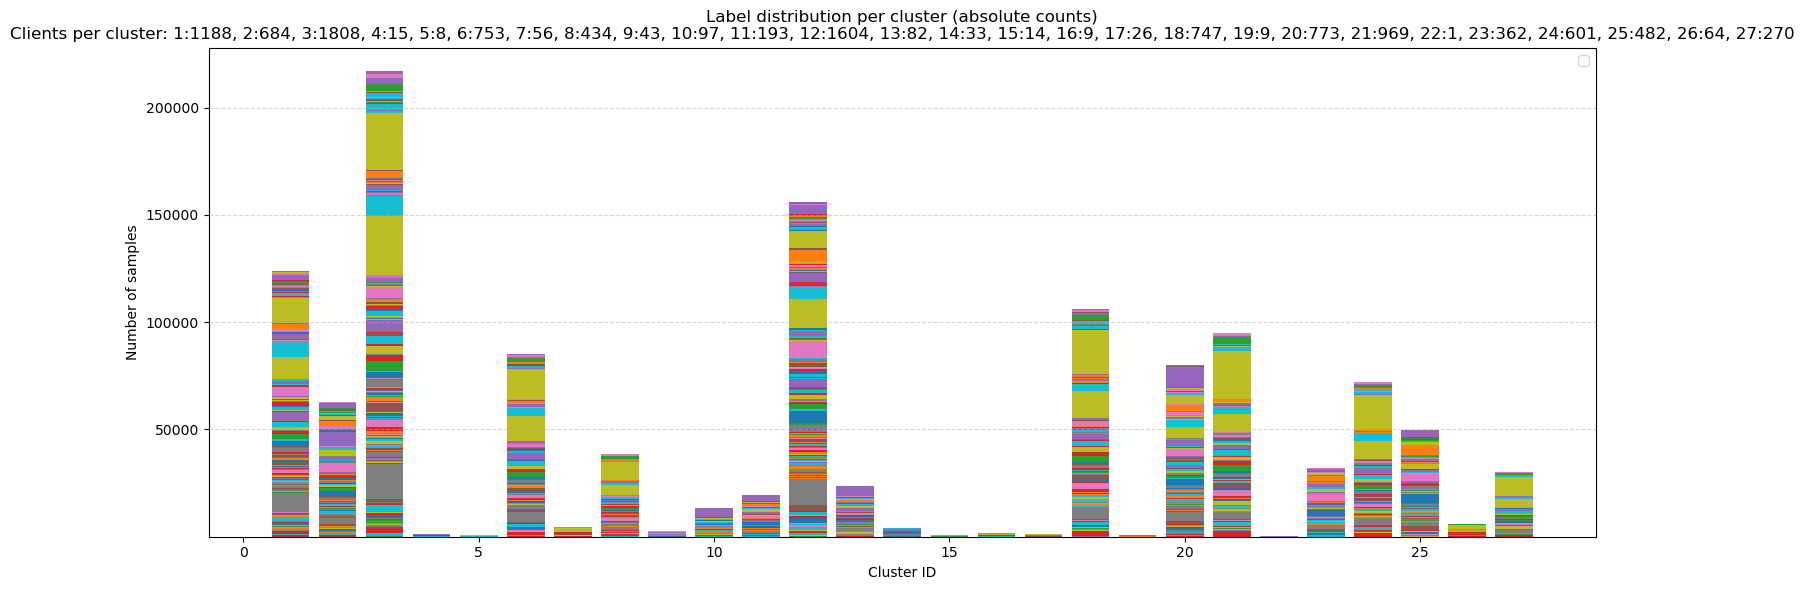

/tmp/ipykernel_939992/1262821038.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))


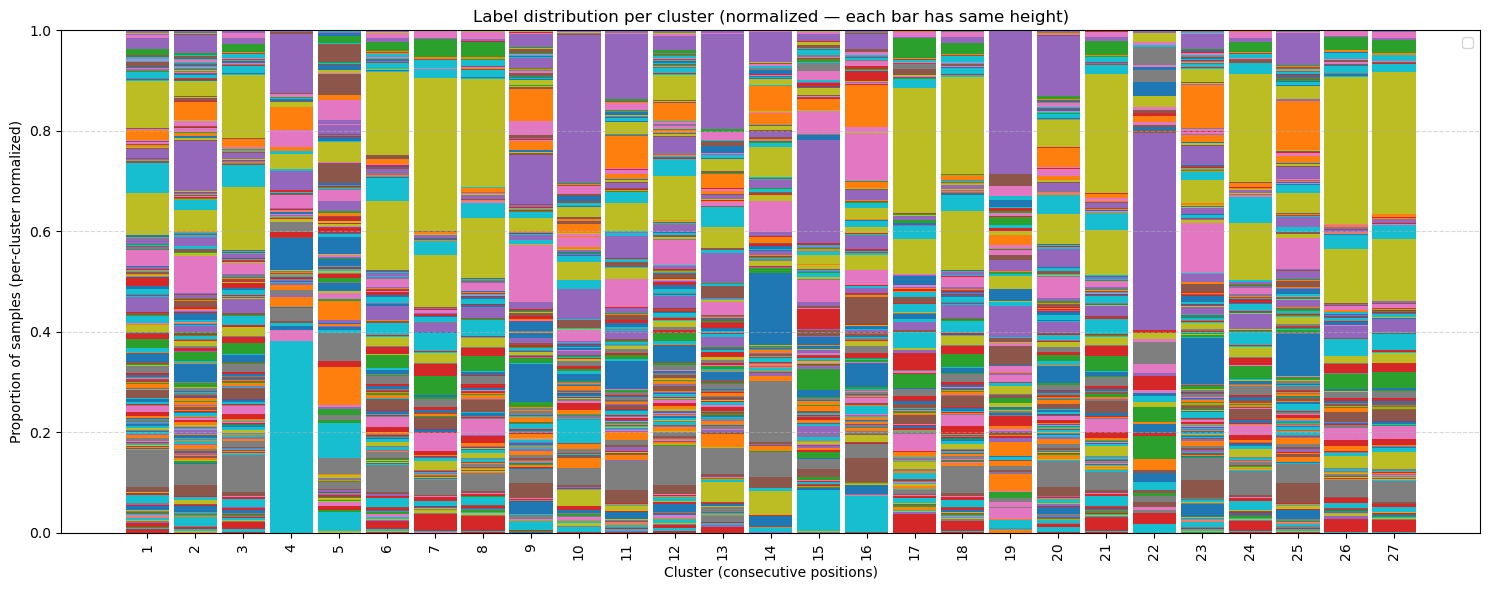

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("../benchmark/dataset/data/openImg_client_data_mapping4")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df["split"] = split
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load cluster mapping
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

model_to_cluster = {}
for c in clusters:
    for m in c["models"]:
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients = pickle.load(f)

# Build client_id -> model
if isinstance(clients, dict):
    client_models = {int(v["id"]): v["model"] for v in clients.values()}
else:  # list-like
    client_models = {int(v["id"]): v["model"] for v in clients}

# Selected clients = those in CSVs
selected_clients = set(df["client_id"].unique())

# Build client_id -> cluster_id
client_to_cluster = {}
for cid in selected_clients:
    model = client_models[cid]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} (client {cid}) not found in clusters.json")
    client_to_cluster[cid] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per cluster
# -----------------------------
cluster_label_counts = defaultdict(Counter)
cluster_clients = defaultdict(set)

for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    clus = client_to_cluster[cid]
    cluster_label_counts[clus][lab] += 1
    cluster_clients[clus].add(cid)

# All labels sorted for deterministic stacking
all_labels = sorted(df["label_name"].unique())

# -----------------------------
# Build DataFrame (clusters x labels)
# -----------------------------
clusters_sorted = sorted(cluster_label_counts.keys())
mat = []
for clus in clusters_sorted:
    counts = [cluster_label_counts[clus][lab] for lab in all_labels]
    mat.append(counts)
mat = pd.DataFrame(mat, index=clusters_sorted, columns=all_labels)

# -----------------------------
# 1) Absolute stacked bar chart
# -----------------------------
fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat[lab].values
    ax.bar(clusters_sorted, vals, bottom=bottom, label=lab, width=0.8)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

ax.set_xlabel("Cluster ID")
ax.set_ylabel("Number of samples")
ax.set_title("Label distribution per cluster (absolute counts)\nClients per cluster: " +
             ", ".join(f"{c}:{len(cluster_clients[c])}" for c in clusters_sorted))
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Normalized stacked bar chart (all bars same total height)
# -----------------------------
# Normalize each cluster row to sum==1 (if a cluster has zero total, keep zeros)
row_sums = mat.sum(axis=1).replace(0, 1)   # avoid division by zero
mat_norm = mat.div(row_sums, axis=0)

fig, ax = plt.subplots(figsize=(15, 6))
bottom = None
for lab in all_labels:
    vals = mat_norm[lab].values
    ax.bar(range(len(clusters_sorted)), vals, bottom=bottom, label=lab, width=0.9)
    if bottom is None:
        bottom = vals.copy()
    else:
        bottom = bottom + vals

# x ticks are consecutive indices; label them with cluster ids for reference
ax.set_xticks(range(len(clusters_sorted)))
ax.set_xticklabels(clusters_sorted, rotation=90)

ax.set_xlabel("Cluster (consecutive positions)")
ax.set_ylabel("Proportion of samples (per-cluster normalized)")
ax.set_title("Label distribution per cluster (normalized — each bar has same height)")
ax.legend(ncol=4, bbox_to_anchor=(1.0, 1.0))
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

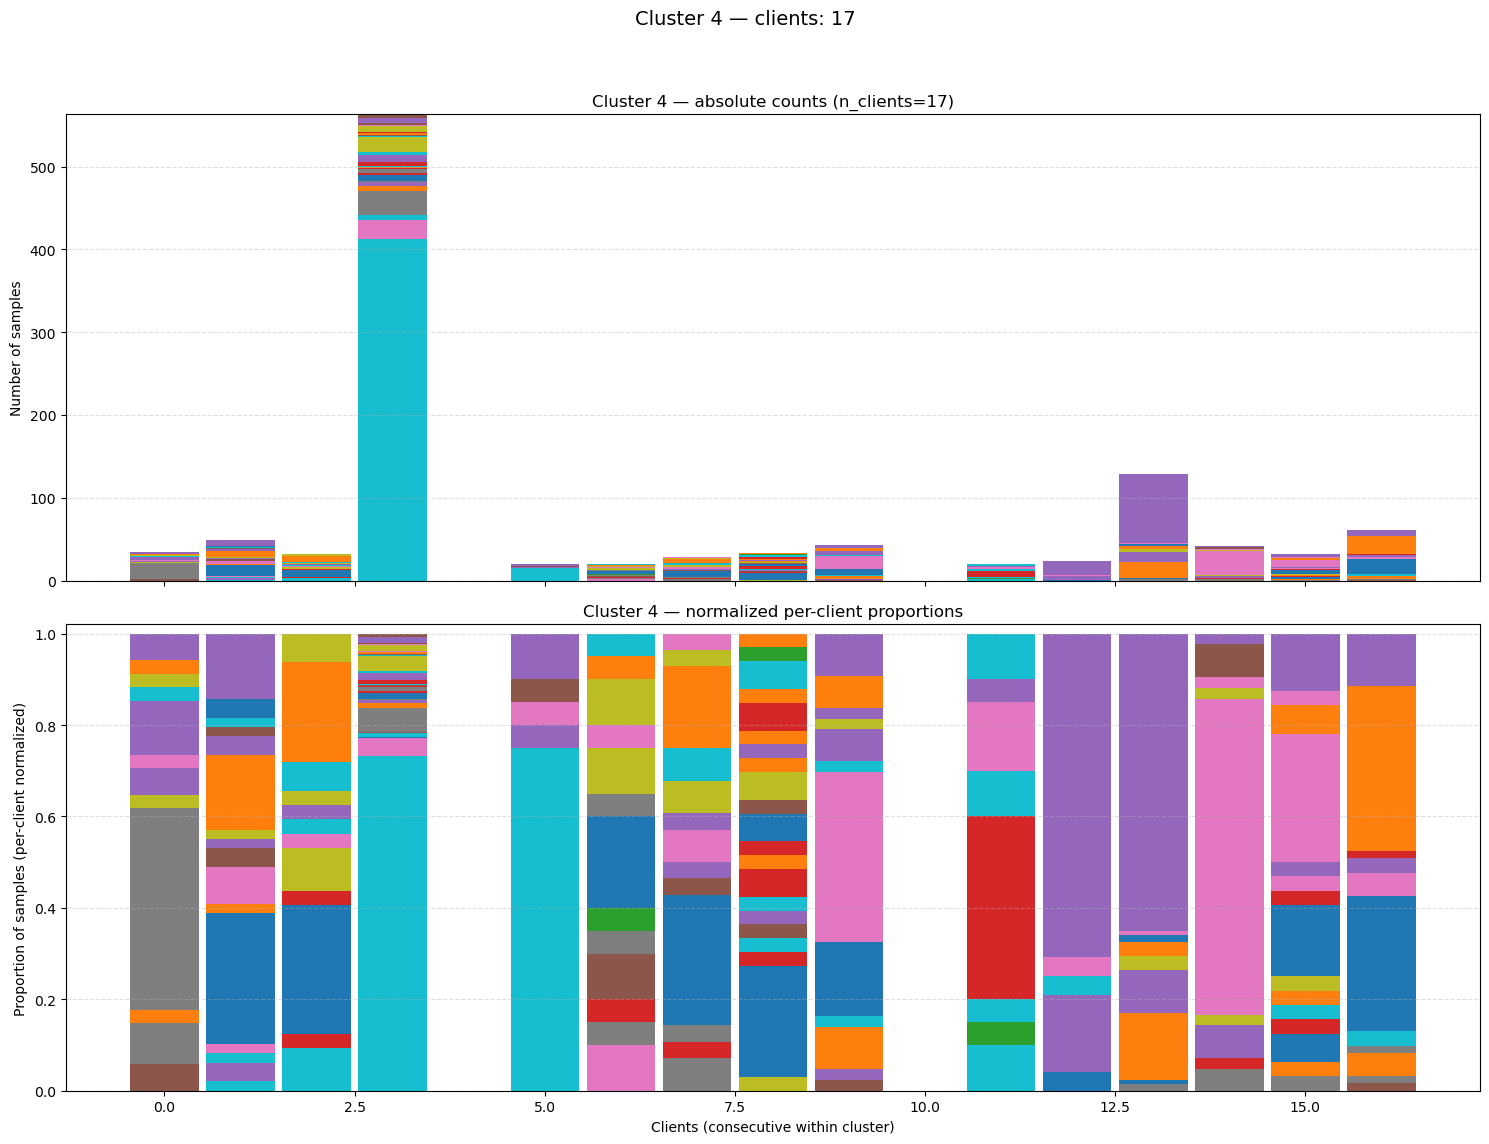

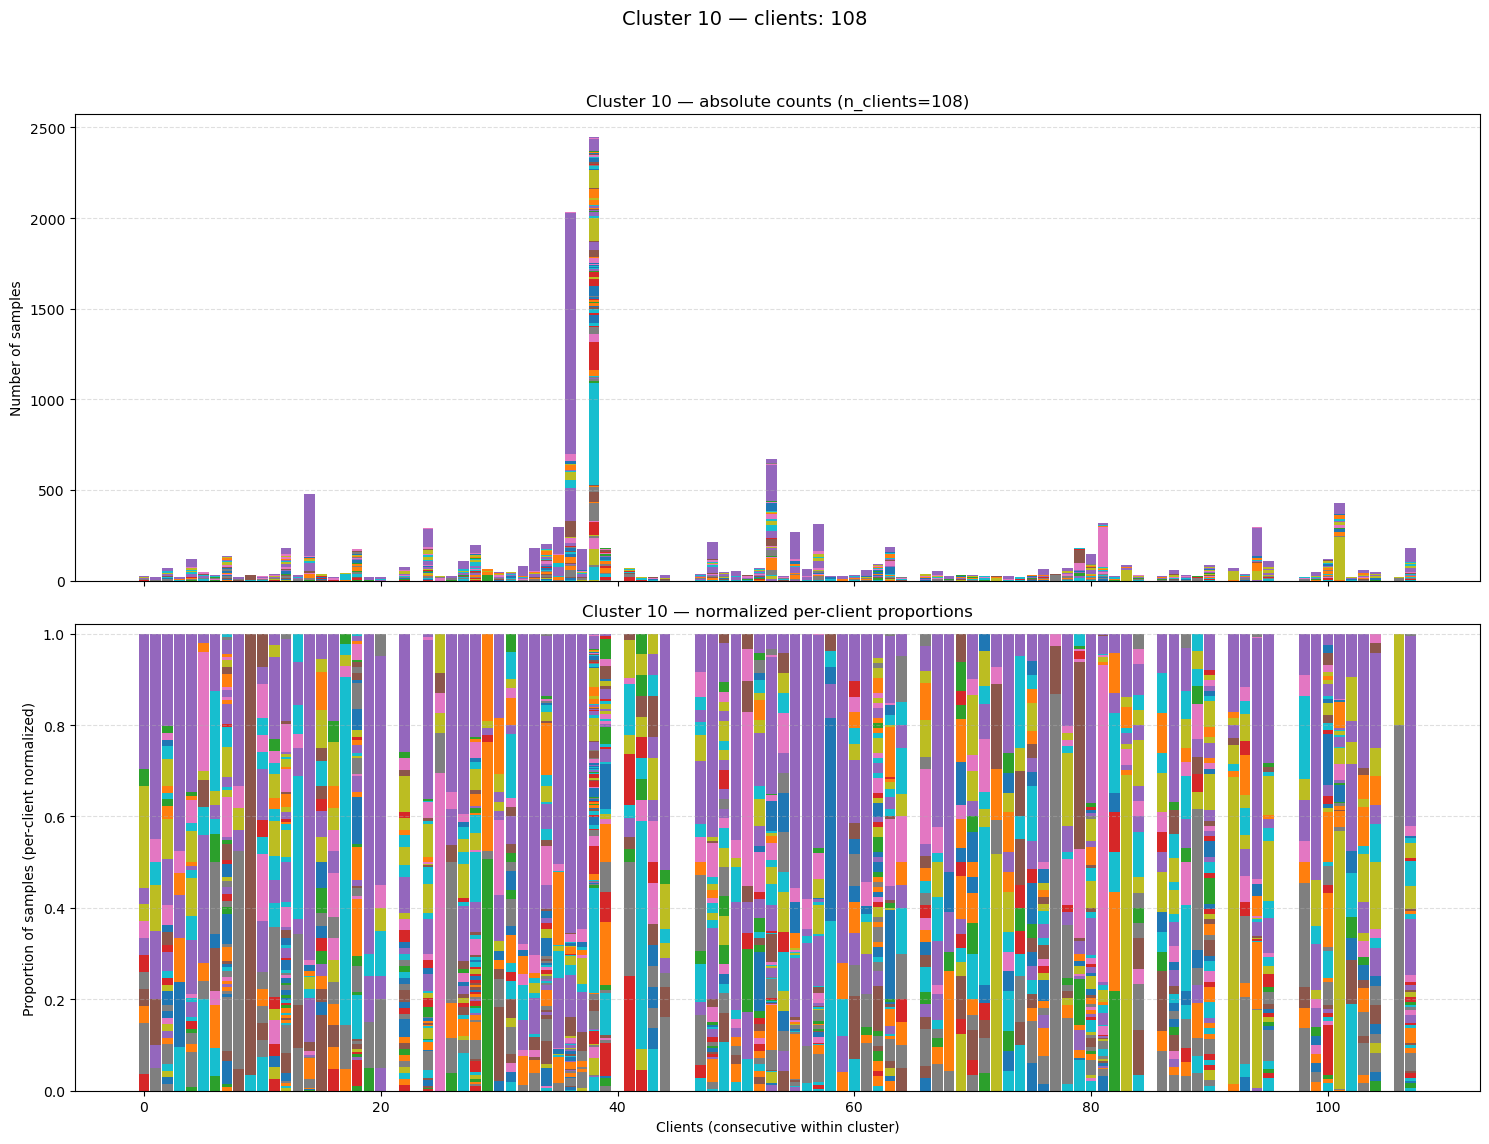

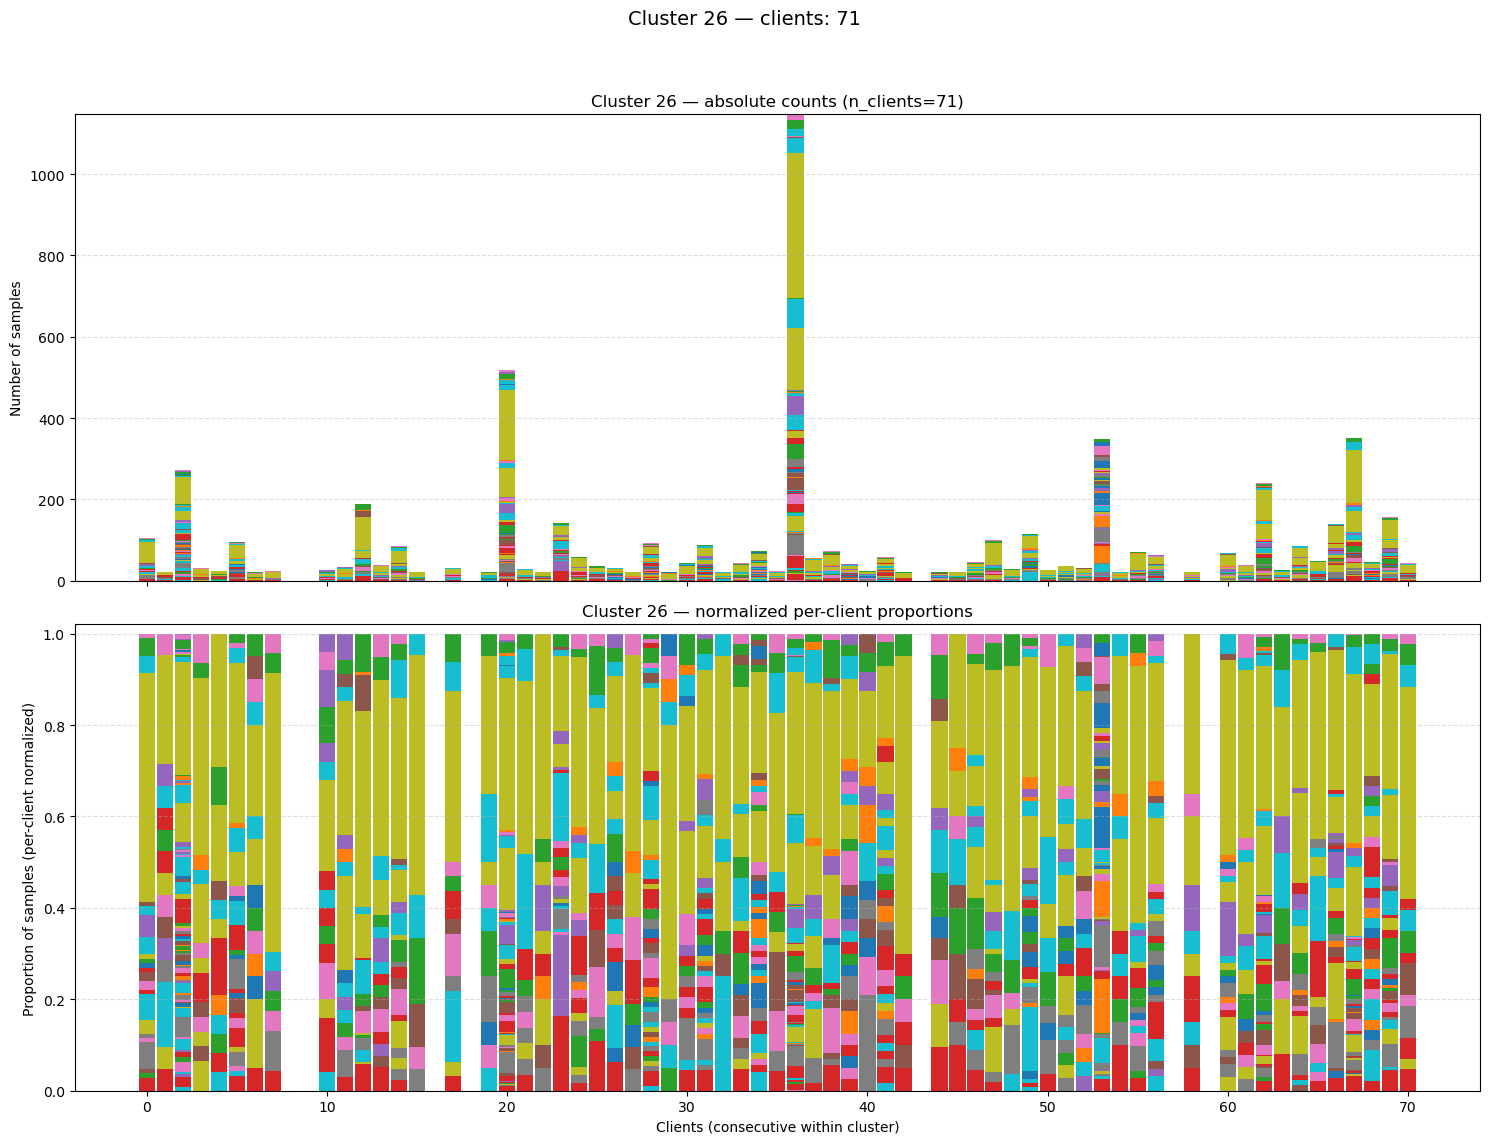

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import json, pickle
from pathlib import Path
from collections import defaultdict, Counter

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("../benchmark/dataset/data/openImg_client_data_mapping4")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

TARGET_CLUSTERS = [4, 10, 26]

# -----------------------------
# Load partition data
# -----------------------------
df_all = []
for split, path in CSV_FILES.items():
    df = pd.read_csv(path)
    df_all.append(df)
df = pd.concat(df_all, ignore_index=True)

# -----------------------------
# Load clusters and clients
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)
model_to_cluster = {}
for c in clusters:
    for m in c.get("models", []):
        model_to_cluster[m] = c["id"]

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

entries.sort(key=lambda t: t[0])
N = int(df["client_id"].max()) + 1
new2old = {i: entries[i][0] for i in range(N)}
oldid_to_model = {old: model for (old, model) in entries}

client_to_cluster = {}
for new_id in range(N):
    model = oldid_to_model[new2old[new_id]]
    if model not in model_to_cluster:
        raise RuntimeError(f"Model {model} not in clusters.json")
    client_to_cluster[new_id] = model_to_cluster[model]

# -----------------------------
# Aggregate label counts per client
# -----------------------------
client_label_counts = defaultdict(Counter)
for _, row in df.iterrows():
    cid = int(row["client_id"])
    lab = row["label_name"]
    client_label_counts[cid][lab] += 1

# -----------------------------
# Plot for target clusters (absolute above, normalized below)
# -----------------------------
labels = sorted(df["label_name"].unique())

for target_cluster in TARGET_CLUSTERS:
    # clients belonging to this cluster (consecutive index 0..M-1 used for plotting)
    cids = [cid for cid, clus in client_to_cluster.items() if clus == target_cluster]
    if not cids:
        print(f"No clients found for cluster {target_cluster}")
        continue

    # Build dataframe: rows = clients (consecutive index), cols = labels (absolute counts)
    mat_abs = []
    for cid in cids:
        mat_abs.append([client_label_counts[cid][lab] for lab in labels])
    mat_abs = pd.DataFrame(mat_abs, index=range(len(cids)), columns=labels)

    # Prepare normalized matrix: each row normalized to sum 1 (avoid division by zero)
    row_sums = mat_abs.sum(axis=1).replace(0, 1)  # keep zeros as zeros after division
    mat_norm = mat_abs.div(row_sums, axis=0)

    # Plot stacked vertically: absolute (top), normalized (bottom)
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(15, 12), sharex=True,
                                         gridspec_kw={'height_ratios': [1, 1]})

    # --- Top: Absolute stacked bar chart ---
    bottom = None
    for lab in labels:
        vals = mat_abs[lab].values
        ax_top.bar(mat_abs.index, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_top.set_ylabel("Number of samples")
    ax_top.set_title(f"Cluster {target_cluster} — absolute counts (n_clients={len(cids)})")
    ax_top.grid(axis="y", linestyle="--", alpha=0.4)

    # --- Bottom: Normalized stacked bar chart (each client bar sums to 1) ---
    bottom = None
    x = list(range(len(cids)))
    for lab in labels:
        vals = mat_norm[lab].values
        ax_bot.bar(x, vals, bottom=bottom, label=lab, width=0.9)
        bottom = vals.copy() if bottom is None else bottom + vals
    ax_bot.set_xlabel("Clients (consecutive within cluster)")
    ax_bot.set_ylabel("Proportion of samples (per-client normalized)")
    ax_bot.set_ylim(0, 1.02)
    ax_bot.set_title(f"Cluster {target_cluster} — normalized per-client proportions")
    ax_bot.grid(axis="y", linestyle="--", alpha=0.4)

    # Legend handling: show only if label count small, else show top-10 labels by count
    if len(labels) <= 20:
        # show full legend below the bottom plot
        ax_bot.legend(ncol=4, bbox_to_anchor=(0.5, -0.35), loc="upper center")
    else:
        cluster_label_totals = mat_abs.sum(axis=0).sort_values(ascending=False)
        topk = cluster_label_totals.index[:10].tolist()
        handles, lablist = ax_bot.get_legend_handles_labels()
        lbl2h = dict(zip(lablist, handles))
        sel_handles = [lbl2h[l] for l in topk if l in lbl2h]
        if sel_handles:
            ax_bot.legend(sel_handles, topk, title="Top labels", bbox_to_anchor=(0.5, -0.35), loc="upper center")

    plt.suptitle(f"Cluster {target_cluster} — clients: {len(cids)}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Detected max client id in CSVs => using N = 12641 clients (ids 0..12640).


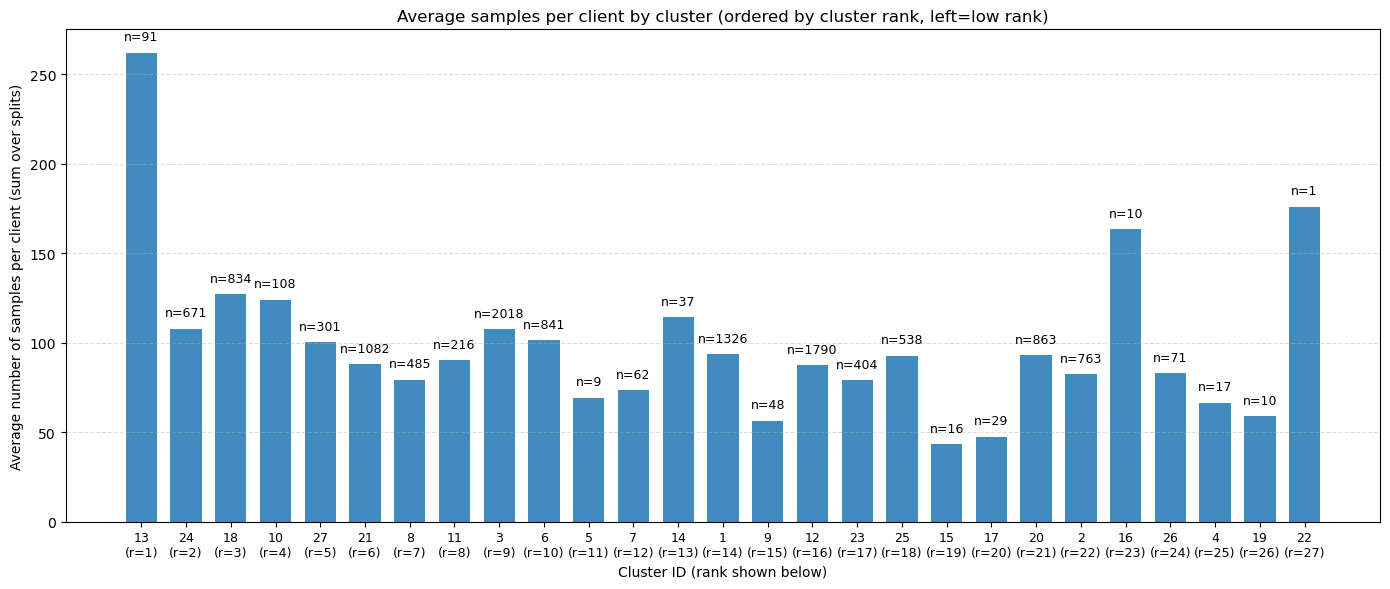

 cluster  rank  n_clients  avg_samples_per_client
      13   1.0         91              261.879121
      24   2.0        671              107.713860
      18   3.0        834              127.068345
      10   4.0        108              123.907407
      27   5.0        301              100.102990
      21   6.0       1082               87.800370
       8   7.0        485               79.286598
      11   8.0        216               90.375000
       3   9.0       2018              107.559960
       6  10.0        841              101.225922
       5  11.0          9               69.333333
       7  12.0         62               73.403226
      14  13.0         37              114.378378
       1  14.0       1326               93.458522
       9  15.0         48               56.479167
      12  16.0       1790               87.269274
      23  17.0        404               79.158416
      25  18.0        538               92.724907
      15  19.0         16               43.375000


In [7]:
import json
import pickle
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config
# -----------------------------
MAPPING_DIR = Path("../benchmark/dataset/data/openImg_client_data_mapping4")
CSV_FILES = {
    "train": MAPPING_DIR / "train.csv",
}
CLUSTERS_JSON = Path("../thirdparty/bliss/clusters.json")
CLIENTS_PKL   = Path("../benchmark/dataset/data/clients.pkl")

# -----------------------------
# Load CSVs and compute per-client total counts
# -----------------------------
dfs = []
for p in CSV_FILES.values():
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")
    dfs.append(pd.read_csv(p))
df = pd.concat(dfs, ignore_index=True)

# Total samples per client across all splits (include clients with zero later)
per_client_counts = df.groupby("client_id").size().to_dict()   # client_id -> count

# Determine N (assume CSVs contain new IDs 0..N-1; N = max_id+1)
N = int(df["client_id"].max()) + 1
print(f"Detected max client id in CSVs => using N = {N} clients (ids 0..{N-1}).")

# Build a dense vector of counts length N (clients with no rows -> 0)
counts_arr = np.zeros(N, dtype=int)
for cid, cnt in per_client_counts.items():
    counts_arr[int(cid)] = int(cnt)

# -----------------------------
# Load clients.pkl and clusters.json and build mapping new_id -> cluster & cluster ranks
# -----------------------------
with open(CLUSTERS_JSON, "r") as f:
    clusters = json.load(f)

# model -> cluster_id mapping (ensure uniqueness) and cluster_id->rank
model_to_cluster = {}
cluster_rank = {}
for c in clusters:
    cid = int(c["id"])
    cluster_rank[cid] = float(c.get("rank", 0.0))
    for m in c.get("models", []):
        if m in model_to_cluster and model_to_cluster[m] != cid:
            raise RuntimeError(f"Model '{m}' appears in multiple clusters ({model_to_cluster[m]} and {cid})")
        model_to_cluster[m] = cid

with open(CLIENTS_PKL, "rb") as f:
    clients_obj = pickle.load(f)

# Build sorted entries (old_id, model) in ascending old_id order (same convention used when generating CSVs)
entries = []
if isinstance(clients_obj, dict):
    for v in clients_obj.values():
        entries.append((int(v["id"]), v["model"]))
elif isinstance(clients_obj, (list, tuple)):
    for v in clients_obj:
        entries.append((int(v["id"]), v["model"]))
else:
    raise TypeError(f"Unsupported clients.pkl type: {type(clients_obj)}")

entries.sort(key=lambda t: t[0])

if len(entries) < N:
    raise RuntimeError(f"clients.pkl has only {len(entries)} entries but we require first N={N}. Aborting.")

# new_id -> old_id mapping (we assume the same remapping as used in the partitioner)
new2old = {i: entries[i][0] for i in range(N)}
old2model = {old: model for (old, model) in entries}

# Build new_id -> cluster mapping (raise if model missing from clusters.json)
client_to_cluster = {}
for new_id in range(N):
    old_id = new2old[new_id]
    model = old2model.get(old_id)
    if model is None:
        raise RuntimeError(f"Old client id {old_id} not found in clients.pkl entries")
    if model not in model_to_cluster:
        raise RuntimeError(f"Model '{model}' (old_id={old_id}, new_id={new_id}) not found in clusters.json")
    client_to_cluster[new_id] = int(model_to_cluster[model])

# -----------------------------
# Aggregate: compute average samples per client for each cluster
# -----------------------------
cluster_to_client_ids = defaultdict(list)
for new_id, cluster_id in client_to_cluster.items():
    cluster_to_client_ids[cluster_id].append(new_id)

# Order clusters by their rank (ascending: rank=1 leftmost, higher ranks to the right).
# If a cluster has no rank entry, use 0.0 by default.
clusters_present = list(cluster_to_client_ids.keys())
clusters_sorted = sorted(clusters_present, key=lambda k: cluster_rank.get(k, 0.0))

cluster_means = []
cluster_counts = []
cluster_ranks_list = []
for k in clusters_sorted:
    cids = cluster_to_client_ids[k]
    arr = counts_arr[cids]                # vector of counts for clients in this cluster (includes zeros)
    mean = float(arr.mean())
    cluster_means.append(mean)
    cluster_counts.append(len(cids))
    cluster_ranks_list.append(cluster_rank.get(k, 0.0))

# -----------------------------
# Plot bar chart: avg samples per client per cluster (ordered by rank)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(clusters_sorted))
ax.bar(x, cluster_means, width=0.7, color="tab:blue", alpha=0.85)
ax.set_xticks(x)

# show cluster id and rank in xtick labels for clarity
xtick_labels = [f"{int(k)}\n(r={cluster_rank.get(k,0):.2g})" for k in clusters_sorted]
ax.set_xticklabels(xtick_labels, rotation=0, fontsize=9)

ax.set_xlabel("Cluster ID (rank shown below)")
ax.set_ylabel("Average number of samples per client (sum over splits)")
ax.set_title("Average samples per client by cluster (ordered by cluster rank, left=low rank)")

# annotate with number of clients above each bar
max_mean = max(cluster_means) if cluster_means else 1.0
for xi, mean, cnt in zip(x, cluster_means, cluster_counts):
    ax.text(xi, mean + max_mean * 0.02, f"n={cnt}", ha="center", va="bottom", fontsize=9)

ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# -----------------------------
# Also print a small table for numeric inspection (ordered by rank)
# -----------------------------
tbl = pd.DataFrame({
    "cluster": clusters_sorted,
    "rank": cluster_ranks_list,
    "n_clients": cluster_counts,
    "avg_samples_per_client": cluster_means,
})
print(tbl.sort_values("rank").to_string(index=False))

In [8]:

from pathlib import Path
import numpy as np
import pandas as pd
import json, pickle

# Simple, intuitive similarity metrics
# - Global centroid cosine: average cosine similarity of each client's normalized label histogram to the global centroid
# - Within-rank cosine: average cosine similarity to the centroid of its assigned rank
# - Across-rank centroid cosine: average cosine similarity between rank centroids (pairwise average)

try:
    _ = label_vectors  # already in memory from Cell 1
    _ = assignment_ranks
    vectors = label_vectors.copy()
    ranks = assignment_ranks.copy()
    print("Using in-memory label_vectors and assignment_ranks.")
except NameError:
    print("Reloading from disk to compute metrics…")
    project_root = Path.cwd().parent
    train_csv_path = project_root / "benchmark/dataset/data/openImg_client_data_mapping4/train.csv"
    clients_path = project_root / "benchmark/dataset/data/clients.pkl"
    clusters_path = project_root / "thirdparty/bliss/clusters.json"

    # Load mapping CSV and compute normalized per-client label histograms
    df = pd.read_csv(train_csv_path)
    group_sizes = df.groupby("client_id").size()
    label_counts = (
        df.groupby(["client_id", "label_id"]).size().unstack(fill_value=0).astype(float)
    )
    label_counts = label_counts.reindex(group_sizes.index, fill_value=0.0)
    vectors = label_counts.to_numpy()
    vectors = vectors + 1e-8
    vectors = vectors / vectors.sum(axis=1, keepdims=True)
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    vectors = vectors / np.clip(norms, 1e-12, None)
    group_ids = group_sizes.index.to_numpy()

    # Map device client_id -> model -> rank
    with open(clients_path, "rb") as f:
        clients_obj = pickle.load(f)
    with open(clusters_path, "r") as f:
        clusters = json.load(f)
    model_to_rank = {}
    for c in clusters:
        r = c.get("rank")
        if r is None: continue
        for m in c.get("models", []) or []:
            if not m: continue
            model_to_rank[m.strip()] = int(r)
            model_to_rank[m.strip().lower()] = int(r)
    id_to_model = {}
    if isinstance(clients_obj, dict):
        for v in clients_obj.values():
            id_to_model[int(v.get("id"))] = v.get("model", "")
    else:
        for v in clients_obj:
            id_to_model[int(v.get("id"))] = v.get("model", "")
    ranks = np.zeros(len(group_ids), dtype=int)
    for i, cid in enumerate(group_ids):
        model = (id_to_model.get(int(cid)) or "").strip()
        rk = model_to_rank.get(model, model_to_rank.get(model.lower(), 0))
        if not rk:
            raise RuntimeError(f"No rank for client_id {cid} (model={model})")
        ranks[i] = rk

# Global centroid metric
global_center = vectors.mean(axis=0)
ng = np.linalg.norm(global_center)
if ng > 1e-12:
    global_center = global_center / ng
cos_global = (vectors @ global_center)

# Per-rank centroids and within-rank metric
unique_ranks = np.unique(ranks)
centroids = {}
for r in unique_ranks:
    idx = (ranks == r)
    if not np.any(idx):
        continue
    c = vectors[idx].mean(axis=0)
    n = np.linalg.norm(c)
    if n > 1e-12:
        c = c / n
    centroids[r] = c
within_vals = []
for i in range(vectors.shape[0]):
    c = centroids.get(int(ranks[i]))
    if c is None: continue
    within_vals.append(float(vectors[i].dot(c)))
within_vals = np.array(within_vals, dtype=float)

# Across-rank centroid similarity (pairwise average)
centroid_list = [centroids[r] for r in sorted(centroids.keys())]
if len(centroid_list) >= 2:
    C = np.stack(centroid_list)
    K = C.shape[0]
    sim_mat = C @ C.T
    iu = np.triu_indices(K, k=1)
    across_centroid_vals = sim_mat[iu]
else:
    across_centroid_vals = np.array([np.nan])

print("Simple label-similarity metrics")
print(f"- Groups: {vectors.shape[0]}, Labels: {vectors.shape[1]}, Active ranks: {len(centroids)}")
print(f"- Global centroid cosine: mean={cos_global.mean():.4f}, std={cos_global.std(ddof=0):.4f}")
print(f"- Within-rank cosine:    mean={within_vals.mean():.4f}, std={within_vals.std(ddof=0):.4f}")
print(f"- Across-rank centroid cosine (pairwise): mean={np.nanmean(across_centroid_vals):.4f}, std={np.nanstd(across_centroid_vals, ddof=0):.4f}")


# Also report client-to-client cosine similarities (pairwise means)
# Using sum-vector identity so it scales to large N without O(N^2) memory.
try:
    X = label_vectors.copy()  # rows are unit L2 norm
    rks = assignment_ranks.copy()
except NameError:
    # Fallback if not in memory: rebuild from saved mapping
    project_root = Path.cwd().parent
    df = pd.read_csv(project_root / 'benchmark/dataset/data/openImg_client_data_mapping4/train.csv')
    group_sizes = df.groupby('client_id').size()
    label_counts = df.groupby(['client_id','label_id']).size().unstack(fill_value=0).astype(float)
    label_counts = label_counts.reindex(group_sizes.index, fill_value=0.0)
    X = label_counts.to_numpy()
    X = X + 1e-8
    X = X / X.sum(axis=1, keepdims=True)
    X = X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)
    # ranks via current assignment: we cannot reconstruct easily without cell 1,
    # so treat all as a single cluster in fallback
    rks = np.ones(X.shape[0], dtype=int)

n = X.shape[0]
V = X.sum(axis=0)
num_pairs_global = n * (n - 1) / 2.0
sum_pair_global = 0.5 * (float(V @ V) - n)
mean_pair_global = sum_pair_global / num_pairs_global if num_pairs_global > 0 else float('nan')

# Within- and across-rank (rank=cluster) client-to-client cosine
within_sum = 0.0
within_pairs = 0.0
per_cluster_means = []
for r in np.unique(rks):
    idx = (rks == r)
    k = int(idx.sum())
    if k < 2:
        continue
    Vr = X[idx].sum(axis=0)
    pairs_r = k * (k - 1) / 2.0
    sum_r = 0.5 * (float(Vr @ Vr) - k)
    within_sum += sum_r
    within_pairs += pairs_r
    per_cluster_means.append(sum_r / pairs_r)

mean_within_weighted = within_sum / within_pairs if within_pairs > 0 else float('nan')
mean_within_unweighted = float(np.mean(per_cluster_means)) if per_cluster_means else float('nan')
across_pairs = num_pairs_global - within_pairs
across_sum = sum_pair_global - within_sum
mean_across = across_sum / across_pairs if across_pairs > 0 else float('nan')

# Build X (unit L2) and rks (rank per client) robustly
try:
    # Preferred: use in-memory vectors (per-group histograms) and assignment ranks
    X = label_vectors.copy()
    rks = assignment_ranks.copy()
    # X rows correspond one-to-one to assigned clients (each group mapped to exactly one client)
except NameError:
    # Fallback: recompute per-client vectors from saved mapping and ranks from clients.pkl + clusters.json
    from pathlib import Path
    import json, pickle
    project_root = Path.cwd().parent
    df = pd.read_csv(project_root / 'benchmark/dataset/data/openImg_client_data_mapping4/train.csv')
    # per-client normalized histograms
    gsz = df.groupby('client_id').size()
    counts = df.groupby(['client_id','label_id']).size().unstack(fill_value=0).astype(float)
    counts = counts.reindex(gsz.index, fill_value=0.0)
    X = counts.to_numpy()
    X = X + 1e-8
    X = X / X.sum(axis=1, keepdims=True)
    X = X / np.clip(np.linalg.norm(X, axis=1, keepdims=True), 1e-12, None)
    # ranks via model->rank
    with open(project_root / 'benchmark/dataset/data/clients.pkl', 'rb') as f:
        clients_obj = pickle.load(f)
    with open(project_root / 'thirdparty/bliss/clusters.json', 'r') as f:
        clusters = json.load(f)
    model_to_rank = {}
    for c in clusters:
        r = c.get('rank')
        if r is None: continue
        for m in c.get('models', []) or []:
            if not m: continue
            model_to_rank[m.strip()] = int(r)
            model_to_rank[m.strip().lower()] = int(r)
    id_to_model = {}
    if isinstance(clients_obj, dict):
        for v in clients_obj.values():
            id_to_model[int(v.get('id'))] = v.get('model','')
    else:
        for v in clients_obj:
            id_to_model[int(v.get('id'))] = v.get('model','')
    cids_sorted = gsz.index.to_numpy()
    rks_list = []
    missing = 0
    for cid in cids_sorted:
        model = (id_to_model.get(int(cid)) or '').strip()
        rk = model_to_rank.get(model, model_to_rank.get(model.lower()))
        if rk is None:
            missing += 1
            rk = 0
        rks_list.append(int(rk))
    if missing:
        print(f'Warning: {missing} clients missing rank; excluded from within/across splits.')
    rks = np.array(rks_list, dtype=int)

# Remove clients without rank if any
mask = rks > 0
if not mask.all():
    X = X[mask]
    rks = rks[mask]

# Global pairwise cosine mean via sum-vector identity
n = X.shape[0]
V = X.sum(axis=0)
num_pairs_global = n * (n - 1) / 2.0
sum_pair_global = 0.5 * (float(V @ V) - n)
mean_pair_global = sum_pair_global / num_pairs_global if num_pairs_global > 0 else float('nan')

# Within- and across-cluster (ranks are clusters) client-to-client cosine
within_sum = 0.0
within_pairs = 0.0
per_cluster_means = []
for r in np.unique(rks):
    idx = (rks == r)
    k = int(idx.sum())
    if k < 2:
        continue
    Vr = X[idx].sum(axis=0)
    pairs_r = k * (k - 1) / 2.0
    sum_r = 0.5 * (float(Vr @ Vr) - k)
    within_sum += sum_r
    within_pairs += pairs_r
    per_cluster_means.append(sum_r / pairs_r)

mean_within_weighted = within_sum / within_pairs if within_pairs > 0 else float('nan')
mean_within_unweighted = float(np.mean(per_cluster_means)) if per_cluster_means else float('nan')
across_pairs = num_pairs_global - within_pairs
across_sum = sum_pair_global - within_sum
mean_across = across_sum / across_pairs if across_pairs > 0 else float('nan')

print('Client label-distribution similarity (cosine)')
print(f'- Global client-to-client cosine (all pairs): mean={mean_pair_global:.4f}')
print(f'- Within-cluster client-to-client cosine:    mean_weighted={mean_within_weighted:.4f}, mean_unweighted={mean_within_unweighted:.4f}')
print(f'- Across-cluster client-to-client cosine:    mean={mean_across:.4f}')


Using in-memory label_vectors and assignment_ranks.
Simple label-similarity metrics
- Groups: 11325, Labels: 595, Active ranks: 27
- Global centroid cosine: mean=0.6532, std=0.2203
- Within-rank cosine:    mean=0.7264, std=0.2028
- Across-rank centroid cosine (pairwise): mean=0.5308, std=0.2755
Client label-distribution similarity (cosine)
- Global client-to-client cosine (all pairs): mean=0.4266
- Within-cluster client-to-client cosine:    mean_weighted=0.5326, mean_unweighted=0.4510
- Across-cluster client-to-client cosine:    mean=0.4163
